<a href="https://colab.research.google.com/github/AmyHumke12/SolarProject/blob/main/IPTV_SolarEdgeData_Step1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This Notebook Sets up the SolarEdge data, Weather, Sun, Electricity use, and expected production for this area datasets.

##Requirements

In [ ]:
!pip install astral
!pip install pandasql
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26772 sha256=0f7f92a1fb8aa9a654cb7ae2d020330eeaa7aa3bf37234c14f7e0aa8e3a435ee
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 2.5 MB/s eta 0:00:00


In [ ]:
#Requirements
import pandas as pd
import pandasql as psql
import numpy as np
import requests
from datetime import datetime, timedelta
import os
from retry_requests import retry
import openmeteo_requests
import requests_cache
import pandasql as psql
import requests
import time
import matplotlib.pyplot as plt
import pytz
import time
from io import BytesIO
from astral import LocationInfo
from astral.sun import sun, elevation, azimuth


In [ ]:
#Get access to google drive
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


#Mount the google drive to save and retrieve files

In [ ]:
#Save secrets
import os

os.environ['SOLAREDGE_API_KEY'] = 'YTLTVN3M2RL1OQFCC6IQA1VI0R2EZBZ5'
os.environ['SOLAREDGE_SITE_ID'] = '4092737'


#Get estimated hourly production by month from GlobalSolarAtas.info

In [ ]:
# Define the solar generation values for each month and hour from the heatmap
solar_data = {
    'Jan': [0, 0, 0, 0, 0, 0, 0.038, 0.494, 2.773, 4.560, 5.780, 6.316, 6.095, 5.351, 4.487, 2.965, 0.571, 0.011, 0, 0, 0, 0, 0, 0],
    'Feb': [0, 0, 0, 0, 0, 0.101, 0.391, 1.353, 3.849, 5.804, 7.220, 7.843, 7.708, 6.917, 5.962, 4.257, 1.959, 0.439, 0, 0, 0, 0, 0, 0],
    'Mar': [0, 0, 0, 0, 0, 0.437, 1.269, 2.490, 4.551, 6.457, 7.729, 8.340, 8.180, 7.412, 6.244, 4.617, 2.504, 0.752, 0, 0, 0, 0, 0, 0],
    'Apr': [0, 0, 0, 0, 0, 0.476, 1.662, 3.384, 5.321, 6.852, 8.020, 8.346, 8.194, 7.513, 6.253, 4.552, 2.527, 1.019, 0.344, 0.029, 0, 0, 0, 0],
    'May': [0, 0, 0, 0, 0, 0.399, 1.662, 3.629, 5.372, 6.873, 7.805, 8.209, 7.948, 7.400, 6.232, 4.648, 2.736, 1.019, 0.107, 0.210, 0, 0, 0, 0],
    'Jun': [0, 0, 0, 0, 0, 0.149, 1.502, 3.674, 5.494, 6.983, 8.071, 8.479, 8.393, 7.819, 6.661, 5.025, 3.063, 1.215, 0.365, 0.344, 0, 0, 0, 0],
    'Jul': [0, 0, 0, 0, 0, 0.065, 1.271, 3.590, 5.641, 7.226, 8.204, 8.664, 8.597, 7.998, 6.856, 5.304, 3.297, 1.345, 0.344, 0.344, 0, 0, 0, 0],
    'Aug': [0, 0, 0, 0, 0, 0.149, 1.065, 3.376, 5.364, 6.990, 8.090, 8.575, 8.473, 7.806, 6.709, 5.066, 2.973, 1.000, 0.107, 0.029, 0, 0, 0, 0],
    'Sep': [0, 0, 0, 0, 0, 0.149, 1.065, 3.323, 5.414, 7.160, 8.211, 8.532, 8.260, 7.526, 6.338, 4.494, 2.973, 1.000, 0.321, 0.344, 0, 0, 0, 0],
    'Oct': [0, 0, 0, 0, 0, 0.488, 2.794, 4.765, 6.248, 7.074, 7.564, 7.261, 6.879, 6.043, 4.860, 3.111, 2.297, 1.000, 0.029, 0.344, 0, 0, 0, 0],
    'Nov': [0, 0, 0, 0, 0, 0.463, 1.507, 3.738, 5.356, 6.324, 6.574, 6.298, 5.511, 4.217, 3.768, 2.219, 1.932, 0.878, 0.107, 0.138, 0, 0, 0, 0],
    'Dec': [0, 0, 0, 0, 0, 0.463, 2.614, 4.237, 5.243, 5.683, 5.427, 5.298, 4.739, 3.768, 3.168, 1.932, 1.000, 0.463, 0.344, 0.107, 0, 0, 0, 0]
}

# Create a list of hours in a day
hours = list(range(24))

# Initialize an empty list to hold the data
data = []

# Loop through each month and hour to populate the dataframe
for month, values in solar_data.items():
    for hour in hours:
        value = values[hour]
        data.append([month, hour, value])

# Create the DataFrame
df_solar = pd.DataFrame(data, columns=['Month', 'Hour', 'Solar_Generation'])

# Display the DataFrame
print(df_solar)


    Month  Hour  Solar_Generation
0     Jan     0             0.000
1     Jan     1             0.000
2     Jan     2             0.000
3     Jan     3             0.000
4     Jan     4             0.000
..    ...   ...               ...
283   Dec    19             0.107
284   Dec    20             0.000
285   Dec    21             0.000
286   Dec    22             0.000
287   Dec    23             0.000

[288 rows x 3 columns]


In [ ]:
df_solar

,Month,Hour,Solar_Generation
0,Jan,0,0.000
1,Jan,1,0.000
2,Jan,2,0.000
3,Jan,3,0.000
4,Jan,4,0.000
...,...,...,...
283,Dec,19,0.107
284,Dec,20,0.000
285,Dec,21,0.000
286,Dec,22,0.000


In [ ]:
# Save the updated DataFrame
df_solar.to_pickle('/content/drive/My Drive/solar_production_estimate.pkl')
print("Data saved.")

Data saved.


#Get Consumption and Production Data from SolarEdge
- Only one month of data is allowed at a time
- Put it in a loop to get the data and keep appending
- If it runs with no data it will still run, if there is data it will check the last date in the file and then run to current date

In [ ]:
def fetch_solaredge_details(start_time, end_time):
    # Retrieve the API key and site ID from environment variables
    api_key = os.getenv('SOLAREDGE_API_KEY')
    site_id = os.getenv('SOLAREDGE_SITE_ID')

    # API URL for fetching energy details
    url = f"https://monitoringapi.solaredge.com/site/{site_id}/energyDetails"

    # Parameters including multiple meters
    params = {
        'meters': 'Production,Consumption,FeedIn,Purchased',  # Fetches all necessary metrics
        'startTime': start_time,
        'endTime': end_time,
        'api_key': api_key,
        'timeUnit': 'HOUR'  # Fetch data at an hourly granularity
    }

    # Make the API request with retry logic
    max_retries = 3
    for attempt in range(max_retries):
        response = requests.get(url, params=params)
        if response.status_code == 200:
            return response.json()  # Returns the JSON response as a Python dictionary
        elif response.status_code == 429:  # Handle rate limit errors
            print(f"Rate limit hit. Retrying after a delay... (Attempt {attempt + 1}/{max_retries})")
            time.sleep(60)  # Wait for 60 seconds before retrying
        else:
            response.raise_for_status()  # Raises an HTTPError for bad responses
    raise Exception(f"Failed to fetch data after {max_retries} attempts.")

def normalize_data(data):
    # Normalize the JSON data into a DataFrame
    meters = data['energyDetails']['meters']
    df_list = []
    for meter in meters:
        df = pd.json_normalize(meter, 'values')
        df['meter_type'] = meter['type']  # Add a column for the meter type
        df_list.append(df)
    solaredge_df = pd.concat(df_list, ignore_index=True)
    return solaredge_df

# Try to load existing data if available
try:
    solaredge_df = pd.read_pickle('/content/drive/My Drive/iptv_solaredge_data_raw.pkl')
    print("Loaded existing data.")
except FileNotFoundError:
    solaredge_df = pd.DataFrame()  # Initialize an empty DataFrame if no file exists
    print("No existing data found, starting fresh.")

# Determine the start date for the new data
if not solaredge_df.empty:
    last_date = pd.to_datetime(solaredge_df['date'].max())
    start_time_dt = last_date + timedelta(days=1)  # last_date is already a Timestamp, so no need to parse it
else:
    start_time_dt = datetime(2024, 1, 1)  # Start date if no existing data

# Calculate the end date as 11:59 PM on the day before today
end_of_yesterday = (datetime.now() - timedelta(days=1)).replace(hour=23, minute=59, second=59, microsecond=0)

# Ensure the start time does not go beyond yesterday
if start_time_dt > end_of_yesterday:
    print("Data is already up-to-date.")
else:
    # Loop to collect data
    while start_time_dt <= end_of_yesterday:
        if start_time_dt.month == datetime.now().month:
            # Fetch data one day at a time for the current month
            end_time_dt = start_time_dt.replace(hour=23, minute=59, second=59)
            time.sleep(1)  # Add a short delay between daily requests to avoid rate limiting
        else:
            # Fetch data one month at a time for previous months
            next_month = (start_time_dt.replace(day=1) + timedelta(days=32)).replace(day=1)
            end_time_dt = min(next_month - timedelta(seconds=1), end_of_yesterday)

        start_time = start_time_dt.strftime('%Y-%m-%d %H:%M:%S')
        end_time = end_time_dt.strftime('%Y-%m-%d %H:%M:%S')

        print(f"Fetching data from {start_time} to {end_time}")
        try:
            data_period = fetch_solaredge_details(start_time, end_time)

            if data_period:
                # Normalize and append the data
                df = normalize_data(data_period)
                solaredge_df = pd.concat([solaredge_df, df], ignore_index=True)

                # Ensure that only distinct rows are kept based on 'date' and 'meter_type'
                solaredge_df = solaredge_df.drop_duplicates(subset=['date', 'meter_type'])
            else:
                print("No data returned for this period.")
        except requests.exceptions.HTTPError as http_err:
            print(f"HTTP error occurred: {http_err}")
            break

        # Move to the next day or month
        if start_time_dt.month == datetime.now().month:
            start_time_dt += timedelta(days=1)
        else:
            start_time_dt = next_month

# Save the updated data
solaredge_df.to_pickle('/content/drive/My Drive/iptv_solaredge_data_raw.pkl')


Loaded existing data.
Fetching data from 2024-01-01 00:00:00 to 2024-01-31 23:59:59
Fetching data from 2024-02-01 00:00:00 to 2024-02-29 23:59:59
Fetching data from 2024-03-01 00:00:00 to 2024-03-31 23:59:59
Fetching data from 2024-04-01 00:00:00 to 2024-04-30 23:59:59
Fetching data from 2024-05-01 00:00:00 to 2024-05-31 23:59:59
Fetching data from 2024-06-01 00:00:00 to 2024-06-30 23:59:59
Fetching data from 2024-07-01 00:00:00 to 2024-07-31 23:59:59
Fetching data from 2024-08-01 00:00:00 to 2024-08-31 23:59:59
Fetching data from 2024-09-01 00:00:00 to 2024-09-01 23:59:59
Fetching data from 2024-09-02 00:00:00 to 2024-09-02 23:59:59
Fetching data from 2024-09-03 00:00:00 to 2024-09-03 23:59:59
Fetching data from 2024-09-04 00:00:00 to 2024-09-04 23:59:59
Fetching data from 2024-09-05 00:00:00 to 2024-09-05 23:59:59
Fetching data from 2024-09-06 00:00:00 to 2024-09-06 23:59:59
Fetching data from 2024-09-07 00:00:00 to 2024-09-07 23:59:59
Fetching data from 2024-09-08 00:00:00 to 2024-0

In [ ]:
# #In case you need to erase the file and start over again

# # Create an empty DataFrame
# empty_df = pd.DataFrame()

# # Save the empty DataFrame to the pickle file, overwriting the existing data
# empty_df.to_pickle('/content/drive/My Drive/iptv_solaredge_data_raw.pkl')

# print("The solaredge_data.pkl file has been erased and replaced with an empty DataFrame.")


The solaredge_data.pkl file has been erased and replaced with an empty DataFrame.


In [ ]:
#Local and timezone methods of getting today's date to return accurately failed. Using this to drop data from 'today' because it is incomplete.

# Ensure the 'date' column is in datetime format
solaredge_df['date'] = pd.to_datetime(solaredge_df['date'])

# Get the current UTC time
utc_now = datetime.utcnow()

# Adjust for the local timezone (assuming your timezone is UTC-5, adjust accordingly)
local_now = utc_now - timedelta(hours=5)

# Extract just the local date
today_date = pd.to_datetime(local_now.date())

# Filter out rows with today's date
solaredge_df = solaredge_df[solaredge_df['date'] < today_date]

# Optional: Display the number of rows remaining
rows_remaining = solaredge_df.shape[0]
print(f"Rows remaining after removing today's data: {rows_remaining}")

# Save the cleaned DataFrame if needed
solaredge_df.to_pickle('/content/drive/My Drive/iptv_solaredge_data_cleaned.pk')


Rows remaining after removing today's data: 25660


In [ ]:
today_date

Timestamp('2024-09-24 00:00:00')

In [ ]:
solaredge_df

,date,meter_type,value
0,2024-01-01 00:00:00,FeedIn,NaN
1,2024-01-01 01:00:00,FeedIn,NaN
2,2024-01-01 02:00:00,FeedIn,NaN
3,2024-01-01 03:00:00,FeedIn,NaN
4,2024-01-01 04:00:00,FeedIn,NaN
...,...,...,...
25655,2024-09-23 19:00:00,Production,0.0
25656,2024-09-23 20:00:00,Production,0.0
25657,2024-09-23 21:00:00,Production,0.0
25658,2024-09-23 22:00:00,Production,0.0


In [ ]:
#Check for duplicates
# Create a combination of 'date' and 'meter_type' as a new column
solaredge_df['date_meter_combination'] = solaredge_df['date'].astype(str) + "_" + solaredge_df['meter_type']

# Find the combinations that have more than one occurrence
duplicate_combinations = solaredge_df['date_meter_combination'].value_counts()

# Filter to keep only those that appear more than once
duplicate_combinations = duplicate_combinations[duplicate_combinations > 1]

# Display the duplicate combinations
print("Duplicate date and meter_type combinations (with more than one occurrence):")
print(duplicate_combinations)


Duplicate date and meter_type combinations (with more than one occurrence):
Series([], Name: count, dtype: int64)


#Check to see if the hours and value generations are actually central time.

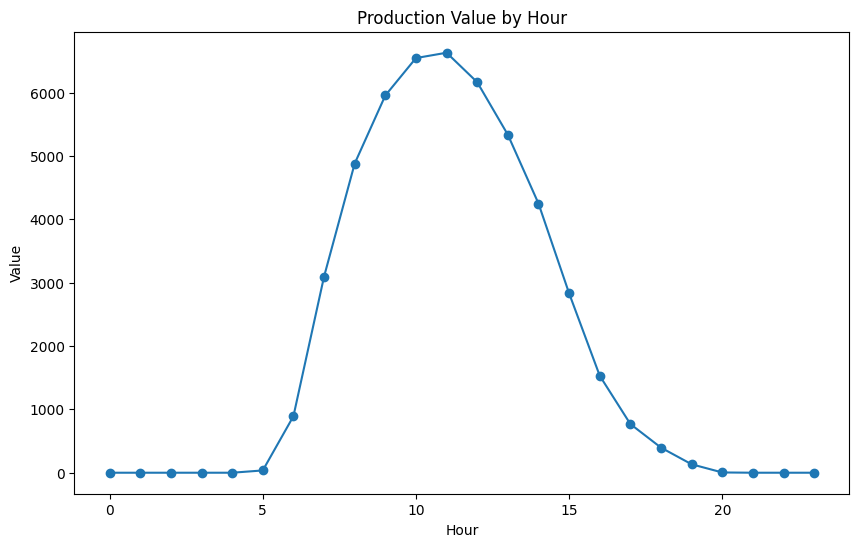

In [ ]:
# Ensure the 'date' column is in datetime format
solaredge_df['date'] = pd.to_datetime(solaredge_df['date'])

# Extract hour from the 'date' column
solaredge_df['hour'] = solaredge_df['date'].dt.hour

# Filter the DataFrame for meter_type = 'Production'
filtered_df = solaredge_df[solaredge_df['meter_type'] == 'Production']

# Group by hour and calculate the mean value for each hour (or sum, if appropriate)
hourly_data = filtered_df.groupby('hour')['value'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(hourly_data['hour'], hourly_data['value'], marker='o')

# Adding titles and labels
plt.title('Production Value by Hour')
plt.xlabel('Hour')
plt.ylabel('Value')

# Display the plot
plt.show()


In [ ]:
solaredge_df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25660 entries, 0 to 25659
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    25660 non-null  datetime64[ns]
 1   meter_type              25660 non-null  object        
 2   value                   14538 non-null  float64       
 3   date_meter_combination  25660 non-null  object        
 4   hour                    25660 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), object(2)
memory usage: 902.2+ KB


In [ ]:
# List the distinct meter types
distinct_meter_types = solaredge_df['meter_type'].unique()

# Display the distinct meter types
print(distinct_meter_types)


['FeedIn' 'Purchased' 'Consumption' 'Production']


#Meter Type Definitions

**Consumption:**

Definition: The total amount of electrical energy used by a household, building, or facility. This includes all the electricity consumed from both the solar production and the grid.
Purpose: Helps to understand the total energy usage, regardless of the source (solar or grid).

**Production:**

Definition: The amount of electrical energy generated by the solar PV (photovoltaic) system. This is the energy produced by your solar panels.
Purpose: Indicates the performance of the solar system and how much energy it contributes to your total consumption.

**Purchased:**

Definition: The amount of electrical energy bought from the grid. This is the energy your system draws from the utility company when the solar production is not sufficient to cover your consumption.
Purpose: Helps track how much energy you rely on from the grid, which directly impacts your utility bills.

**Feed-In:**

Definition: The amount of excess electrical energy generated by the solar system that is not consumed on-site and is fed back into the grid. In some cases, you might receive credit or payment for this excess energy.
Purpose: Indicates how much energy is sent back to the grid, which can reduce overall energy costs if you’re on a net metering plan.

In [ ]:
# Ensure the 'date' column is in datetime format if it's not already
solaredge_df['date'] = pd.to_datetime(solaredge_df['date'])

# Filter the DataFrame for the date '2024-08-20' and meter_type 'Consumption'
filtered_df = solaredge_df[(solaredge_df['date'].dt.date == pd.to_datetime('2024-08-01').date()) &
                           (solaredge_df['meter_type'] == 'Consumption')]

# Display the filtered DataFrame
filtered_df


,date,meter_type,value,date_meter_combination,hour
21964,2024-08-01 00:00:00,Consumption,1252.0,2024-08-01 00:00:00_Consumption,0
21965,2024-08-01 01:00:00,Consumption,1247.0,2024-08-01 01:00:00_Consumption,1
21966,2024-08-01 02:00:00,Consumption,1245.0,2024-08-01 02:00:00_Consumption,2
21967,2024-08-01 03:00:00,Consumption,1191.0,2024-08-01 03:00:00_Consumption,3
21968,2024-08-01 04:00:00,Consumption,910.0,2024-08-01 04:00:00_Consumption,4
21969,2024-08-01 05:00:00,Consumption,997.0,2024-08-01 05:00:00_Consumption,5
21970,2024-08-01 06:00:00,Consumption,1737.0,2024-08-01 06:00:00_Consumption,6
21971,2024-08-01 07:00:00,Consumption,1393.0,2024-08-01 07:00:00_Consumption,7
21972,2024-08-01 08:00:00,Consumption,1793.0,2024-08-01 08:00:00_Consumption,8
21973,2024-08-01 09:00:00,Consumption,2062.0,2024-08-01 09:00:00_Consumption,9


In [ ]:
# Ensure the 'date' column is in datetime format if it's not already
solaredge_df['date'] = pd.to_datetime(solaredge_df['date'])

# Filter the DataFrame for the date '2024-08-31' and meter_type 'Consumption'
filtered_df = solaredge_df[(solaredge_df['date'].dt.date == pd.to_datetime('2024-08-31').date()) &
                           (solaredge_df['meter_type'] == 'Consumption')]

# Display the filtered DataFrame
filtered_df

,date,meter_type,value,date_meter_combination,hour
22684,2024-08-31 00:00:00,Consumption,1206.0,2024-08-31 00:00:00_Consumption,0
22685,2024-08-31 01:00:00,Consumption,1259.0,2024-08-31 01:00:00_Consumption,1
22686,2024-08-31 02:00:00,Consumption,1226.0,2024-08-31 02:00:00_Consumption,2
22687,2024-08-31 03:00:00,Consumption,1257.0,2024-08-31 03:00:00_Consumption,3
22688,2024-08-31 04:00:00,Consumption,1343.0,2024-08-31 04:00:00_Consumption,4
22689,2024-08-31 05:00:00,Consumption,1316.0,2024-08-31 05:00:00_Consumption,5
22690,2024-08-31 06:00:00,Consumption,1270.0,2024-08-31 06:00:00_Consumption,6
22691,2024-08-31 07:00:00,Consumption,1601.0,2024-08-31 07:00:00_Consumption,7
22692,2024-08-31 08:00:00,Consumption,2482.0,2024-08-31 08:00:00_Consumption,8
22693,2024-08-31 09:00:00,Consumption,2110.0,2024-08-31 09:00:00_Consumption,9


In [ ]:
# Divide the 'value' column by 1000
solaredge_df['value'] = solaredge_df['value'] / 1000

# Display the first few rows to verify the changes
print(solaredge_df.head())


                 date meter_type  value      date_meter_combination  hour
0 2024-01-01 00:00:00     FeedIn    NaN  2024-01-01 00:00:00_FeedIn     0
1 2024-01-01 01:00:00     FeedIn    NaN  2024-01-01 01:00:00_FeedIn     1
2 2024-01-01 02:00:00     FeedIn    NaN  2024-01-01 02:00:00_FeedIn     2
3 2024-01-01 03:00:00     FeedIn    NaN  2024-01-01 03:00:00_FeedIn     3
4 2024-01-01 04:00:00     FeedIn    NaN  2024-01-01 04:00:00_FeedIn     4


In [ ]:
# Filter the DataFrame for the date '2024-08-31' and meter_type 'Consumption'
filtered_df = solaredge_df[(solaredge_df['date'].dt.date == pd.to_datetime('2024-08-31').date()) &
                           (solaredge_df['meter_type'] == 'Production')]

# Display the filtered DataFrame
filtered_df

,date,meter_type,value,date_meter_combination,hour
21940,2024-08-31 00:00:00,Production,0.000,2024-08-31 00:00:00_Production,0
21941,2024-08-31 01:00:00,Production,0.000,2024-08-31 01:00:00_Production,1
21942,2024-08-31 02:00:00,Production,0.000,2024-08-31 02:00:00_Production,2
21943,2024-08-31 03:00:00,Production,0.000,2024-08-31 03:00:00_Production,3
21944,2024-08-31 04:00:00,Production,0.000,2024-08-31 04:00:00_Production,4
21945,2024-08-31 05:00:00,Production,0.000,2024-08-31 05:00:00_Production,5
21946,2024-08-31 06:00:00,Production,0.330,2024-08-31 06:00:00_Production,6
21947,2024-08-31 07:00:00,Production,5.957,2024-08-31 07:00:00_Production,7
21948,2024-08-31 08:00:00,Production,9.126,2024-08-31 08:00:00_Production,8
21949,2024-08-31 09:00:00,Production,10.704,2024-08-31 09:00:00_Production,9


In [ ]:
# Save the updated DataFrame
solaredge_df.to_pickle('/content/drive/My Drive/iptv_solaredge_data_cleaned.pkl')
print("Data saved.")


Data saved.


In [ ]:
solaredge_df

,date,meter_type,value,date_meter_combination,hour
0,2024-01-01 00:00:00,FeedIn,NaN,2024-01-01 00:00:00_FeedIn,0
1,2024-01-01 01:00:00,FeedIn,NaN,2024-01-01 01:00:00_FeedIn,1
2,2024-01-01 02:00:00,FeedIn,NaN,2024-01-01 02:00:00_FeedIn,2
3,2024-01-01 03:00:00,FeedIn,NaN,2024-01-01 03:00:00_FeedIn,3
4,2024-01-01 04:00:00,FeedIn,NaN,2024-01-01 04:00:00_FeedIn,4
...,...,...,...,...,...
25655,2024-09-23 19:00:00,Production,0.0,2024-09-23 19:00:00_Production,19
25656,2024-09-23 20:00:00,Production,0.0,2024-09-23 20:00:00_Production,20
25657,2024-09-23 21:00:00,Production,0.0,2024-09-23 21:00:00_Production,21
25658,2024-09-23 22:00:00,Production,0.0,2024-09-23 22:00:00_Production,22


#Historical Weather Data
- Historical Source:https://open-meteo.com/en/docs/historical-forecast-api#hourly=temperature_2m,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high
**Key Features of the Code:**
- **Start Date Calculation:**

- If the table is empty, it starts from 2022-01-01 00:00:00.
If data exists, it finds the latest timestamp in the table and starts from the next hour.
- **End Date Calculation:**

- The script continues fetching data until the end of yesterday (end_of_yesterday).

Appending Data:

- Data is appended to the DataFrame, ensuring that the latest data is continuously updated.

In [ ]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Try to load existing weather data if available
try:
    weather_hourly_dataframe = pd.read_pickle('/content/drive/My Drive/iptv_weather_data.pkl')
    print("Loaded existing weather data.")
except FileNotFoundError:
    weather_hourly_dataframe = pd.DataFrame()  # Initialize an empty DataFrame if no file exists
    print("No existing weather data found, starting fresh.")

# Determine the start date for the new data
if not weather_hourly_dataframe.empty:
    # Find the max date in the existing data and start from the next hour
    last_date = pd.to_datetime(weather_hourly_dataframe['date'].max())  # Convert to Timestamp
    start_time_dt = last_date + timedelta(hours=1)
else:
    # Start date if no existing data
    start_time_dt = datetime(2022, 1, 1, 0, 0, 0)

# Convert start_time_dt to timezone-aware datetime
start_time_dt = start_time_dt.replace(tzinfo=pytz.utc).astimezone(pytz.timezone('America/Chicago'))

# Calculate the end date as 11:59 PM six days before today in Chicago timezone
end_of_six_days_ago = (datetime.now(pytz.timezone('America/Chicago')) - timedelta(days=6)).replace(hour=23, minute=59, second=59, microsecond=0)

# Loop to collect data in monthly increments
while start_time_dt <= end_of_six_days_ago:
    # Set the end time to the end of the month
    next_month_start = (start_time_dt.replace(day=1) + timedelta(days=32)).replace(day=1)
    end_time_dt = min(next_month_start - timedelta(seconds=1), end_of_six_days_ago)

    start_time = start_time_dt.strftime('%Y-%m-%d')
    end_time = end_time_dt.strftime('%Y-%m-%d')

    print(f"Fetching weather data from {start_time_dt.strftime('%Y-%m-%d %H:%M:%S')} to {end_time_dt.strftime('%Y-%m-%d %H:%M:%S')}")

    # Fetch the data for the current month
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": 42.2871, #This latitude is what the webpage generated for this location
        "longitude": -88.0411,  #This longitude is what the webpage generated for this location
        "start_date": start_time_dt.strftime('%Y-%m-%d'),
        "end_date": end_time_dt.strftime('%Y-%m-%d'),
        "hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "precipitation",
                   "snowfall", "snow_depth", "cloud_cover", "cloud_cover_low", "cloud_cover_mid",
                   "cloud_cover_high", "wind_speed_10m", "wind_gusts_10m", "is_day",
                   "sunshine_duration", "global_tilted_irradiance"],
        "temperature_unit": "fahrenheit",
        "wind_speed_unit": "mph",
        "precipitation_unit": "inch",
        "timezone": "America/Denver", #Trying to get chicago time but the webpage API is off
        "tilt": 30,
        "azimuth": 90
    }

    try:
        responses = openmeteo.weather_api(url, params=params)
    except openmeteo_requests.OpenMeteoRequestsError as e:
        print(f"Rate limit hit or another issue occurred: {e}. Waiting for 60 seconds before retrying...")
        time.sleep(60)  # Wait for 60 seconds before retrying
        continue  # Skip to the next iteration of the loop

    response = responses[0]

    # Process hourly data
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
    hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
    hourly_precipitation = hourly.Variables(3).ValuesAsNumpy()
    hourly_snowfall = hourly.Variables(4).ValuesAsNumpy()
    hourly_snow_depth = hourly.Variables(5).ValuesAsNumpy()
    hourly_cloud_cover = hourly.Variables(6).ValuesAsNumpy()
    hourly_cloud_cover_low = hourly.Variables(7).ValuesAsNumpy()
    hourly_cloud_cover_mid = hourly.Variables(8).ValuesAsNumpy()
    hourly_cloud_cover_high = hourly.Variables(9).ValuesAsNumpy()
    hourly_wind_speed_10m = hourly.Variables(10).ValuesAsNumpy()
    hourly_wind_gusts_10m = hourly.Variables(11).ValuesAsNumpy()
    hourly_is_day = hourly.Variables(12).ValuesAsNumpy()
    hourly_sunshine_duration = hourly.Variables(13).ValuesAsNumpy()
    hourly_global_tilted_irradiance = hourly.Variables(14).ValuesAsNumpy()

    # Convert to timezone-aware datetime
    chicago_tz = pytz.timezone('America/Chicago')
    hourly_start_time = pd.to_datetime(hourly.Time(), unit="s", utc=True).tz_convert(chicago_tz)
    hourly_end_time = pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True).tz_convert(chicago_tz)

    hourly_data = {"date": pd.date_range(
        start=hourly_start_time,
        end=hourly_end_time,
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    )}
    hourly_data["temperature_2m"] = hourly_temperature_2m
    hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
    hourly_data["dew_point_2m"] = hourly_dew_point_2m
    hourly_data["precipitation"] = hourly_precipitation
    hourly_data["snowfall"] = hourly_snowfall
    hourly_data["snow_depth"] = hourly_snow_depth
    hourly_data["cloud_cover"] = hourly_cloud_cover
    hourly_data["cloud_cover_low"] = hourly_cloud_cover_low
    hourly_data["cloud_cover_mid"] = hourly_cloud_cover_mid
    hourly_data["cloud_cover_high"] = hourly_cloud_cover_high
    hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
    hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m
    hourly_data["is_day"] = hourly_is_day
    hourly_data["sunshine_duration"] = hourly_sunshine_duration
    hourly_data["global_tilted_irradiance"] = hourly_global_tilted_irradiance

    # Create a DataFrame for the current month's data
    monthly_dataframe = pd.DataFrame(data=hourly_data)

    # Ensure no duplicate data is appended
    if not weather_hourly_dataframe.empty:
        # Check if the new data overlaps with existing data
        existing_timestamps = weather_hourly_dataframe['date']
        new_timestamps = monthly_dataframe['date']
        monthly_dataframe = monthly_dataframe[~new_timestamps.isin(existing_timestamps)]

    if not monthly_dataframe.empty:
        # Append the new data to the existing DataFrame
        weather_hourly_dataframe = pd.concat([weather_hourly_dataframe, monthly_dataframe], ignore_index=True)
        print(f"Data for {start_time} to {end_time} appended successfully.")
    else:
        print(f"No new data to append for {start_time} to {end_time}.")

    # Move to the next month
    start_time_dt = next_month_start

    # Optional: Add a small delay between requests to reduce the risk of hitting the rate limit
    time.sleep(1)  # Sleep for 1 second before the next request

# Save the updated DataFrame to the pickle file
weather_hourly_dataframe.to_pickle('/content/drive/My Drive/iptv_weather_data.pkl')
print("Weather data saved.")


Loaded existing weather data.
Fetching weather data from 2021-12-31 18:00:00 to 2022-01-01 17:59:59
Data for 2021-12-31 to 2022-01-01 appended successfully.
Fetching weather data from 2022-01-01 18:00:00 to 2022-02-01 17:59:59
Data for 2022-01-01 to 2022-02-01 appended successfully.
Fetching weather data from 2022-02-01 18:00:00 to 2022-03-01 17:59:59
Data for 2022-02-01 to 2022-03-01 appended successfully.
Fetching weather data from 2022-03-01 18:00:00 to 2022-04-01 17:59:59
Data for 2022-03-01 to 2022-04-01 appended successfully.
Fetching weather data from 2022-04-01 18:00:00 to 2022-05-01 17:59:59
Data for 2022-04-01 to 2022-05-01 appended successfully.
Fetching weather data from 2022-05-01 18:00:00 to 2022-06-01 17:59:59
Data for 2022-05-01 to 2022-06-01 appended successfully.
Fetching weather data from 2022-06-01 18:00:00 to 2022-07-01 17:59:59
Data for 2022-06-01 to 2022-07-01 appended successfully.
Fetching weather data from 2022-07-01 18:00:00 to 2022-08-01 17:59:59
Data for 20

In [ ]:
weather_hourly_dataframe

,date,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,snowfall,snow_depth,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,wind_speed_10m,wind_gusts_10m,is_day,sunshine_duration,global_tilted_irradiance
0,2021-12-31 00:00:00-06:00,30.799400,92.598465,28.909401,0.0,0.0,0.131234,60.299999,67.0,0.0,0.0,6.267593,11.856100,0.0,0.0,0.0
1,2021-12-31 01:00:00-06:00,29.179399,92.888649,27.379400,0.0,0.0,0.131234,87.299995,97.0,0.0,0.0,6.109918,11.632400,0.0,0.0,0.0
2,2021-12-31 02:00:00-06:00,29.629400,93.591866,28.009399,0.0,0.0,0.131234,89.099998,99.0,0.0,0.0,6.105822,11.408700,0.0,0.0,0.0
3,2021-12-31 03:00:00-06:00,29.449400,93.586723,27.829399,0.0,0.0,0.131234,90.000000,100.0,0.0,0.0,5.317288,11.184999,0.0,0.0,0.0
4,2021-12-31 04:00:00-06:00,28.729401,94.262344,27.289400,0.0,0.0,0.131234,71.099998,79.0,0.0,0.0,3.257121,9.842800,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23827,2024-09-18 20:00:00-05:00,68.869400,62.318451,55.459400,0.0,0.0,NaN,30.000002,0.0,0.0,100.0,5.002084,8.948000,0.0,0.0,0.0
23828,2024-09-18 21:00:00-05:00,67.609398,65.930824,55.819401,0.0,0.0,NaN,30.000002,0.0,0.0,100.0,4.501876,8.053200,0.0,0.0,0.0
23829,2024-09-18 22:00:00-05:00,67.159401,66.743866,55.729401,0.0,0.0,NaN,30.000002,0.0,0.0,100.0,4.966946,7.382100,0.0,0.0,0.0
23830,2024-09-18 23:00:00-05:00,66.259399,70.213364,56.269402,0.0,0.0,NaN,30.000002,0.0,0.0,100.0,4.343469,7.382100,0.0,0.0,0.0


In [ ]:
weather_hourly_dataframe.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23832 entries, 0 to 23831
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype                          
---  ------                    --------------  -----                          
 0   date                      23832 non-null  datetime64[ns, America/Chicago]
 1   temperature_2m            23832 non-null  float32                        
 2   relative_humidity_2m      23832 non-null  float32                        
 3   dew_point_2m              23832 non-null  float32                        
 4   precipitation             23832 non-null  float32                        
 5   snowfall                  23832 non-null  float32                        
 6   snow_depth                23322 non-null  float32                        
 7   cloud_cover               23832 non-null  float32                        
 8   cloud_cover_low           23832 non-null  float32                        
 9   cloud_cover_mid  

In [ ]:
# Convert the 'date' field to datetime format with nanosecond precision
weather_hourly_dataframe['date'] = pd.to_datetime(weather_hourly_dataframe['date'], errors='coerce')

# Verify the conversion
print(weather_hourly_dataframe.info())
print(weather_hourly_dataframe.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23832 entries, 0 to 23831
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype                          
---  ------                    --------------  -----                          
 0   date                      23832 non-null  datetime64[ns, America/Chicago]
 1   temperature_2m            23832 non-null  float32                        
 2   relative_humidity_2m      23832 non-null  float32                        
 3   dew_point_2m              23832 non-null  float32                        
 4   precipitation             23832 non-null  float32                        
 5   snowfall                  23832 non-null  float32                        
 6   snow_depth                23322 non-null  float32                        
 7   cloud_cover               23832 non-null  float32                        
 8   cloud_cover_low           23832 non-null  float32                        
 9   cloud_cover_mid  

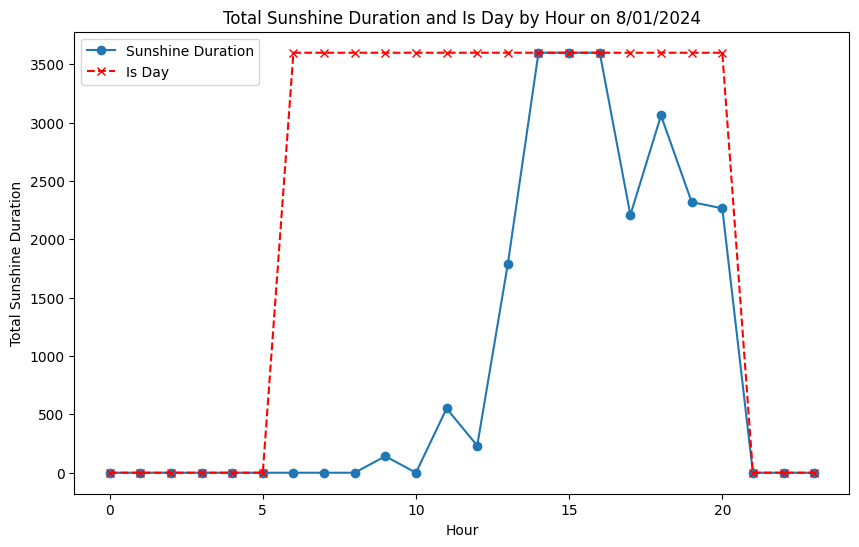

In [ ]:
#Show sunshine duration by hours to check date timestamp alignmnet with timezone.
import matplotlib.pyplot as plt

# Filter the DataFrame for the specific date
specific_date = '2024-08-01'
filtered_df = weather_hourly_dataframe[weather_hourly_dataframe['date'].dt.strftime('%Y-%m-%d') == specific_date].copy()

# Extract the hour from the 'date' column
filtered_df['hour'] = filtered_df['date'].dt.hour

# Group by hour and sum the sunshine duration (though for a single day, summing isn't strictly necessary)
hourly_sunshine = filtered_df.groupby('hour')[['sunshine_duration', 'is_day']].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))

# Plot sunshine duration
plt.plot(hourly_sunshine['hour'], hourly_sunshine['sunshine_duration'], marker='o', label='Sunshine Duration')

# Plot is_day on the same graph, scaled to the range of sunshine duration
plt.plot(hourly_sunshine['hour'], hourly_sunshine['is_day'] * hourly_sunshine['sunshine_duration'].max(),
         marker='x', linestyle='--', color='red', label='Is Day')

# Adding titles and labels
plt.title('Total Sunshine Duration and Is Day by Hour on 8/01/2024')
plt.xlabel('Hour')
plt.ylabel('Total Sunshine Duration')
plt.legend()

# Display the plot
plt.show()


In [ ]:
# Ensure 'date' is in datetime format
weather_hourly_dataframe['date'] = pd.to_datetime(weather_hourly_dataframe['date'])

# Filter the DataFrame for the specific date and select only 'date' and 'is_day' columns
filtered_df = weather_hourly_dataframe.loc[
    weather_hourly_dataframe['date'].dt.strftime('%Y-%m-%d') == '2024-08-01',
    ['date', 'is_day']
]

# Display the filtered DataFrame
print(filtered_df)


                           date  is_day
22655 2024-08-01 00:00:00-05:00     0.0
22656 2024-08-01 01:00:00-05:00     0.0
22657 2024-08-01 02:00:00-05:00     0.0
22658 2024-08-01 03:00:00-05:00     0.0
22659 2024-08-01 04:00:00-05:00     0.0
22660 2024-08-01 05:00:00-05:00     0.0
22661 2024-08-01 06:00:00-05:00     1.0
22662 2024-08-01 07:00:00-05:00     1.0
22663 2024-08-01 08:00:00-05:00     1.0
22664 2024-08-01 09:00:00-05:00     1.0
22665 2024-08-01 10:00:00-05:00     1.0
22666 2024-08-01 11:00:00-05:00     1.0
22667 2024-08-01 12:00:00-05:00     1.0
22668 2024-08-01 13:00:00-05:00     1.0
22669 2024-08-01 14:00:00-05:00     1.0
22670 2024-08-01 15:00:00-05:00     1.0
22671 2024-08-01 16:00:00-05:00     1.0
22672 2024-08-01 17:00:00-05:00     1.0
22673 2024-08-01 18:00:00-05:00     1.0
22674 2024-08-01 19:00:00-05:00     1.0
22675 2024-08-01 20:00:00-05:00     1.0
22676 2024-08-01 21:00:00-05:00     0.0
22677 2024-08-01 22:00:00-05:00     0.0
22678 2024-08-01 23:00:00-05:00     0.0


In [ ]:
# #ONLY IN EMERGENCY - To clear out the existing table so I can start fresh with new data
# # Create an empty DataFrame
# empty_df = pd.DataFrame()

# # Save the empty DataFrame to the pickle file, effectively clearing out the old data
# empty_df.to_pickle('/content/drive/My Drive/iptv_weather_data.pkl')

# print("The weather_data.pkl file has been cleared and replaced with an empty DataFrame.")


The weather_data.pkl file has been cleared and replaced with an empty DataFrame.


In [ ]:
# Display the min and max date in the DataFrame
min_date = weather_hourly_dataframe['date'].min()
max_date = weather_hourly_dataframe['date'].max()

print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")


Minimum date: 2021-12-31 00:00:00-06:00
Maximum date: 2024-09-19 00:00:00-05:00


In [ ]:
weather_hourly_dataframe

,date,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,snowfall,snow_depth,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,wind_speed_10m,wind_gusts_10m,is_day,sunshine_duration,global_tilted_irradiance
0,2021-12-31 00:00:00-06:00,30.799400,92.598465,28.909401,0.0,0.0,0.131234,60.299999,67.0,0.0,0.0,6.267593,11.856100,0.0,0.0,0.0
1,2021-12-31 01:00:00-06:00,29.179399,92.888649,27.379400,0.0,0.0,0.131234,87.299995,97.0,0.0,0.0,6.109918,11.632400,0.0,0.0,0.0
2,2021-12-31 02:00:00-06:00,29.629400,93.591866,28.009399,0.0,0.0,0.131234,89.099998,99.0,0.0,0.0,6.105822,11.408700,0.0,0.0,0.0
3,2021-12-31 03:00:00-06:00,29.449400,93.586723,27.829399,0.0,0.0,0.131234,90.000000,100.0,0.0,0.0,5.317288,11.184999,0.0,0.0,0.0
4,2021-12-31 04:00:00-06:00,28.729401,94.262344,27.289400,0.0,0.0,0.131234,71.099998,79.0,0.0,0.0,3.257121,9.842800,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23827,2024-09-18 20:00:00-05:00,68.869400,62.318451,55.459400,0.0,0.0,NaN,30.000002,0.0,0.0,100.0,5.002084,8.948000,0.0,0.0,0.0
23828,2024-09-18 21:00:00-05:00,67.609398,65.930824,55.819401,0.0,0.0,NaN,30.000002,0.0,0.0,100.0,4.501876,8.053200,0.0,0.0,0.0
23829,2024-09-18 22:00:00-05:00,67.159401,66.743866,55.729401,0.0,0.0,NaN,30.000002,0.0,0.0,100.0,4.966946,7.382100,0.0,0.0,0.0
23830,2024-09-18 23:00:00-05:00,66.259399,70.213364,56.269402,0.0,0.0,NaN,30.000002,0.0,0.0,100.0,4.343469,7.382100,0.0,0.0,0.0


In [ ]:
#Duplicates in the dataframe weren't able to be removed via other methods and they did not carry distinct data so just dropped.
# Drop duplicates in place
weather_hourly_dataframe.drop_duplicates(inplace=True)


In [ ]:
# Assuming 'date_range' is supposed to be a range of datetimes
weather_hourly_dataframe['date'] = pd.date_range(start="2022-01-01", periods=len(weather_hourly_dataframe), freq='H')


In [ ]:
# Find the date_x values that have more than one occurrence
duplicate_date_x = weather_hourly_dataframe['date'].value_counts()

# Filter to keep only those that appear more than once
duplicate_date_x = duplicate_date_x[duplicate_date_x > 1]

# Display the duplicate date_x values
print("Duplicate date_x timestamps (with more than one occurrence):")
print(duplicate_date_x)


Duplicate date_x timestamps (with more than one occurrence):
Series([], Name: count, dtype: int64)


In [ ]:
# Save the updated DataFrame to the pickle file
weather_hourly_dataframe.to_pickle('/content/drive/My Drive/iptv_weather_data_cleaned.pkl')
print("Weather data saved.")

Weather data saved.


#Electric Data

In [ ]:
# Correct Google Sheets ID
sheet_id = "1sd0RsLIxi6WN-tPn-DykxQ51WIZofurX"
sheet_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=xlsx"

# Fetch the file
response = requests.get(sheet_url)

# If the request was successful, read the Excel file into a DataFrame
if response.status_code == 200:
    # Use BytesIO to treat the content as a file
    file_data = BytesIO(response.content)

    # Read the Excel file
    electric = pd.read_excel(file_data)

    # Display the first few rows of the DataFrame
    print(electric.head())
else:
    print(f"Failed to download the file. Status code: {response.status_code}")


/usr/local/lib/python3.10/dist-packages/openpyxl/packaging/custom.py:213: UserWarning: Unknown type for ContentTypeId
  warn(f"Unknown type for {prop.name}")
/usr/local/lib/python3.10/dist-packages/openpyxl/packaging/custom.py:213: UserWarning: Unknown type for _activity
  warn(f"Unknown type for {prop.name}")


             TYPE       DATE START_TIME  END_TIME  USAGE_(kWh)  COST  \
0  Electric usage 2023-01-01   00:00:00  00:29:00         0.72  0.11   
1  Electric usage 2023-01-01   00:30:00  00:59:00         0.74  0.11   
2  Electric usage 2023-01-01   01:00:00  01:29:00         0.75  0.10   
3  Electric usage 2023-01-01   01:30:00  01:59:00         0.77  0.07   
4  Electric usage 2023-01-01   02:00:00  02:29:00         0.69  0.06   

   ESTIMATED_USAGE  NOTES  
0              NaN    NaN  
1              NaN    NaN  
2              NaN    NaN  
3              NaN    NaN  
4              NaN    NaN  


In [ ]:
# Convert the DATE column to datetime if it's not already in datetime format
electric['DATE'] = pd.to_datetime(electric['DATE'])

# Filter the DataFrame for the specific date '8/23/2024'
filtered_electric = electric[electric['DATE'] == '2024-08-23']

# Display the filtered DataFrame
filtered_electric


,TYPE,DATE,START_TIME,END_TIME,USAGE_(kWh),COST,ESTIMATED_USAGE,NOTES
28794,Electric usage,2024-08-23,00:00:00,00:29:00,1.22,0.17,1.40,NaN
28795,Electric usage,2024-08-23,00:30:00,00:59:00,0.48,0.07,0.93,NaN
28796,Electric usage,2024-08-23,01:00:00,01:29:00,0.52,0.07,0.77,NaN
28797,Electric usage,2024-08-23,01:30:00,01:59:00,0.50,0.07,1.11,NaN
28798,Electric usage,2024-08-23,02:00:00,02:29:00,0.50,0.07,0.62,NaN
28799,Electric usage,2024-08-23,02:30:00,02:59:00,0.49,0.07,1.00,NaN
28800,Electric usage,2024-08-23,03:00:00,03:29:00,0.47,0.06,0.68,NaN
28801,Electric usage,2024-08-23,03:30:00,03:59:00,0.47,0.06,1.05,NaN
28802,Electric usage,2024-08-23,04:00:00,04:29:00,0.52,0.07,0.57,NaN
28803,Electric usage,2024-08-23,04:30:00,04:59:00,0.51,0.07,0.94,NaN


In [ ]:
# Step 1: Convert 'DATE' to string and ensure 'START_TIME' is also a string before concatenating
electric['starttimestamp'] = pd.to_datetime(electric['DATE'].astype(str) + ' ' + electric['START_TIME'].astype(str), errors='coerce')

# Step 2: Convert 'DATE' to string and ensure 'END_TIME' is also a string before concatenating
electric['endtimestamp'] = pd.to_datetime(electric['DATE'].astype(str) + ' ' + electric['END_TIME'].astype(str), errors='coerce')

# Step 3: Create 'last_day_month' column with the last day of the month for each date
electric['last_day_month'] = pd.to_datetime(electric['DATE']).dt.to_period('M').dt.to_timestamp('M')

# Display the first few rows to verify
print(electric.head())


             TYPE       DATE START_TIME  END_TIME  USAGE_(kWh)  COST  \
0  Electric usage 2023-01-01   00:00:00  00:29:00         0.72  0.11   
1  Electric usage 2023-01-01   00:30:00  00:59:00         0.74  0.11   
2  Electric usage 2023-01-01   01:00:00  01:29:00         0.75  0.10   
3  Electric usage 2023-01-01   01:30:00  01:59:00         0.77  0.07   
4  Electric usage 2023-01-01   02:00:00  02:29:00         0.69  0.06   

   ESTIMATED_USAGE  NOTES      starttimestamp        endtimestamp  \
0              NaN    NaN 2023-01-01 00:00:00 2023-01-01 00:29:00   
1              NaN    NaN 2023-01-01 00:30:00 2023-01-01 00:59:00   
2              NaN    NaN 2023-01-01 01:00:00 2023-01-01 01:29:00   
3              NaN    NaN 2023-01-01 01:30:00 2023-01-01 01:59:00   
4              NaN    NaN 2023-01-01 02:00:00 2023-01-01 02:29:00   

  last_day_month  
0     2023-01-31  
1     2023-01-31  
2     2023-01-31  
3     2023-01-31  
4     2023-01-31  


In [ ]:
# Ensure 'START_TIME' is converted to a string before splitting, and fill NaNs with a default value
electric['hour'] = electric['START_TIME'].fillna('00:00').astype(str).str.split(':').str[0].astype(int)

# Display the first few rows to verify
print(electric.head())


             TYPE       DATE START_TIME  END_TIME  USAGE_(kWh)  COST  \
0  Electric usage 2023-01-01   00:00:00  00:29:00         0.72  0.11   
1  Electric usage 2023-01-01   00:30:00  00:59:00         0.74  0.11   
2  Electric usage 2023-01-01   01:00:00  01:29:00         0.75  0.10   
3  Electric usage 2023-01-01   01:30:00  01:59:00         0.77  0.07   
4  Electric usage 2023-01-01   02:00:00  02:29:00         0.69  0.06   

   ESTIMATED_USAGE  NOTES      starttimestamp        endtimestamp  \
0              NaN    NaN 2023-01-01 00:00:00 2023-01-01 00:29:00   
1              NaN    NaN 2023-01-01 00:30:00 2023-01-01 00:59:00   
2              NaN    NaN 2023-01-01 01:00:00 2023-01-01 01:29:00   
3              NaN    NaN 2023-01-01 01:30:00 2023-01-01 01:59:00   
4              NaN    NaN 2023-01-01 02:00:00 2023-01-01 02:29:00   

  last_day_month  hour  
0     2023-01-31     0  
1     2023-01-31     0  
2     2023-01-31     1  
3     2023-01-31     1  
4     2023-01-31     2  


In [ ]:
# Function to clean and convert the COST column
def clean_cost(value):
    if isinstance(value, str):
        # Remove dollar sign and commas
        value = value.replace('$', '').replace(',', '')
        # Handle negative values in parentheses
        if '(' in value and ')' in value:
            value = '-' + value.replace('(', '').replace(')', '')
        return float(value)
    else:
        # If the value is already a float, return it as is
        return value

# Apply the cleaning function to the COST column
electric['COST'] = electric['COST'].apply(clean_cost)

# Group by DATE, hour, and last_day_month, then aggregate
electric_agg = electric.groupby(['DATE', 'hour', 'last_day_month']).agg({
    'USAGE_(kWh)': 'sum',
    'COST': 'sum',
    'ESTIMATED_USAGE':'sum'
}).reset_index()

# Create the date_timestamp column
electric_agg['date_timestamp'] = pd.to_datetime(electric_agg['DATE']) + pd.to_timedelta(electric_agg['hour'].astype(int), unit='h')

# Display the new aggregated DataFrame
print(electric_agg.head())

        DATE  hour last_day_month  USAGE_(kWh)  COST  ESTIMATED_USAGE  \
0 2023-01-01     0     2023-01-31         1.46  0.22              0.0   
1 2023-01-01     1     2023-01-31         1.52  0.17              0.0   
2 2023-01-01     2     2023-01-31         1.14  0.24              0.0   
3 2023-01-01     3     2023-01-31         1.64  0.41              0.0   
4 2023-01-01     4     2023-01-31         2.74  0.14              0.0   

       date_timestamp  
0 2023-01-01 00:00:00  
1 2023-01-01 01:00:00  
2 2023-01-01 02:00:00  
3 2023-01-01 03:00:00  
4 2023-01-01 04:00:00  


In [ ]:
# Find the date_timestamp values that have more than one occurrence
duplicate_date_x = electric_agg['date_timestamp'].value_counts()

# Filter to keep only those that appear more than once
duplicate_date_x = duplicate_date_x[duplicate_date_x > 1]

# Display the duplicate date_x values
print("Duplicate date_x timestamps (with more than one occurrence):")
print(duplicate_date_x)

Duplicate date_x timestamps (with more than one occurrence):
Series([], Name: count, dtype: int64)


In [ ]:
# Ensure the 'DATE' column is in datetime format
electric_agg['DATE'] = pd.to_datetime(electric_agg['DATE'])

# Step 1: Handle division by zero when calculating cost_per_kWh
# Replace zero values in 'USAGE_(kWh)' with np.nan or a small number to avoid division by zero
electric_agg['USAGE_(kWh)'].replace(0, np.nan, inplace=True)

# Step 2: Calculate the cost per unit (kWh)
electric_agg['cost_per_kWh'] = electric_agg['COST'] / electric_agg['USAGE_(kWh)']


# Display the first few rows to inspect the new column
print(electric_agg.head())


        DATE  hour last_day_month  USAGE_(kWh)  COST  ESTIMATED_USAGE  \
0 2023-01-01     0     2023-01-31         1.46  0.22              0.0   
1 2023-01-01     1     2023-01-31         1.52  0.17              0.0   
2 2023-01-01     2     2023-01-31         1.14  0.24              0.0   
3 2023-01-01     3     2023-01-31         1.64  0.41              0.0   
4 2023-01-01     4     2023-01-31         2.74  0.14              0.0   

       date_timestamp  cost_per_kWh  
0 2023-01-01 00:00:00      0.150685  
1 2023-01-01 01:00:00      0.111842  
2 2023-01-01 02:00:00      0.210526  
3 2023-01-01 03:00:00      0.250000  
4 2023-01-01 04:00:00      0.051095  


#Fix the usage data between 1/1/2024-8/24/2024

In [ ]:
# Ensure 'DATE' column is in datetime format
electric_agg['DATE'] = pd.to_datetime(electric_agg['DATE'])

# Define the date range
start_date = pd.Timestamp('2024-01-01')
end_date = pd.Timestamp('2024-08-31')

# Replace 'USAGE_(kWh)' with 'ESTIMATED_USAGE' for the specified date range
electric_agg.loc[(electric_agg['DATE'] >= start_date) & (electric_agg['DATE'] <= end_date), 'USAGE_(kWh)'] = electric_agg['ESTIMATED_USAGE']

# Display the first few rows to verify
print(electric_agg[(electric_agg['DATE'] >= start_date) & (electric_agg['DATE'] <= end_date)].head())


           DATE  hour last_day_month  USAGE_(kWh)  COST  ESTIMATED_USAGE  \
8759 2024-01-01     0     2024-01-31         1.46  0.27             1.46   
8760 2024-01-01     1     2024-01-31         1.52  0.26             1.52   
8761 2024-01-01     2     2024-01-31         1.14  0.13             1.14   
8762 2024-01-01     3     2024-01-31         1.64  0.12             1.64   
8763 2024-01-01     4     2024-01-31         2.74  0.11             2.74   

          date_timestamp  cost_per_kWh  
8759 2024-01-01 00:00:00      0.183673  
8760 2024-01-01 01:00:00      0.120370  
8761 2024-01-01 02:00:00      0.063725  
8762 2024-01-01 03:00:00      0.115385  
8763 2024-01-01 04:00:00      0.117021  


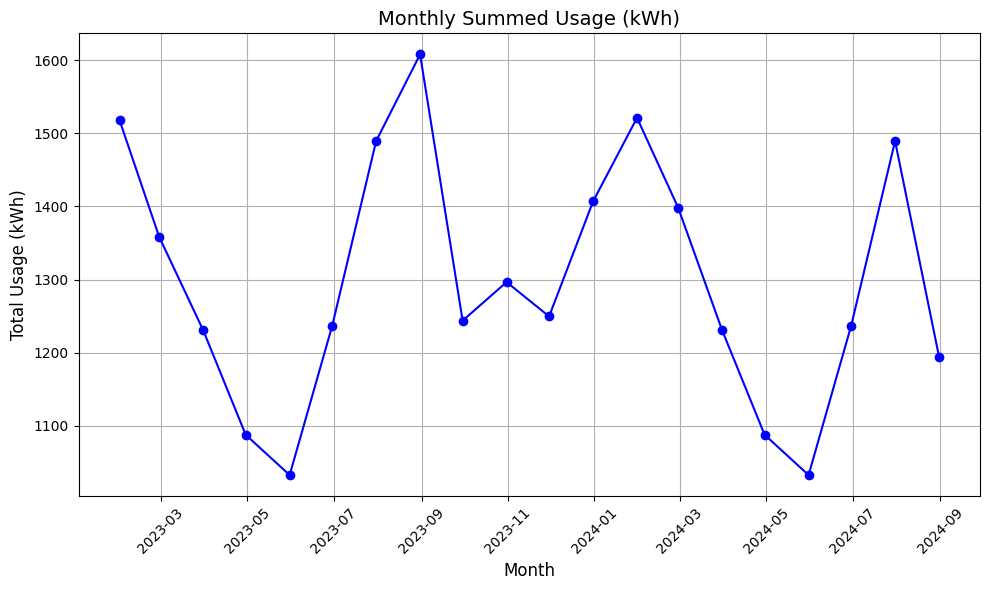

In [ ]:
# Ensure 'DATE' is in datetime format
electric_agg['DATE'] = pd.to_datetime(electric_agg['DATE'])

# Step 1: Resample the data by month and sum the 'USAGE_(kWh)'
monthly_usage = electric_agg.resample('M', on='DATE')['USAGE_(kWh)'].sum()

# Step 2: Plot the monthly summed usage
plt.figure(figsize=(10, 6))
plt.plot(monthly_usage.index, monthly_usage.values, marker='o', linestyle='-', color='b')

# Adding titles and labels
plt.title('Monthly Summed Usage (kWh)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Usage (kWh)', fontsize=12)

# Display the plot
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Save the updated DataFrame
electric_agg.to_pickle('/content/drive/My Drive/iptv_electric_data_cleaned.pkl')
print("Electric data saved.")

Electric data saved.


#Sun Data
- Identify the hours and dates where the sun is up in northern Illinois
- Also get the angle of the sun and distance it is away from the earth

In [ ]:
# Set up location for Mundelein, Illinois
location = LocationInfo("Mundelein", "USA", "America/Chicago", 42.2871, -88.0411)
timezone = pytz.timezone(location.timezone)

# Create an empty list to store the results
daylight_data = []

# Generate data for each day of the year
start_date = datetime(2022, 1, 1)
end_date = datetime(2034, 12, 31)
current_date = start_date

while current_date <= end_date:
    try:
        # Calculate the sun's events for the current date
        sun_info = sun(location.observer, date=current_date)

        # Ensure sunrise and sunset are in the local timezone
        sunrise = sun_info['sunrise'].astimezone(timezone)
        sunset = sun_info['sunset'].astimezone(timezone)

    except ValueError as e:
        print(f"Error for {current_date.date()}: {e}. Defaulting to previous day values if available.")
        sunrise = previous_sunrise if 'previous_sunrise' in locals() else None
        sunset = previous_sunset if 'previous_sunset' in locals() else None

    # Store sunrise and sunset for potential reuse
    previous_sunrise = sunrise
    previous_sunset = sunset

    # Get the sunrise and sunset hours
    sunrise_hour = sunrise.hour if sunrise else None
    sunset_hour = sunset.hour if sunset else None

    # Iterate over each hour of the day
    for hour in range(24):
        current_time = timezone.localize(current_date.replace(hour=hour, minute=0, second=0))
        is_daylight = 0

        if sunrise_hour is not None and sunset_hour is not None:
            if hour == sunrise_hour:
                # Calculate daylight duration within the sunrise hour
                daylight_duration = (60 - sunrise.minute)  # minutes of daylight within the sunrise hour
                if daylight_duration >= 15:
                    is_daylight = 1
            elif hour == sunset_hour:
                # Calculate daylight duration within the sunset hour
                daylight_duration = sunset.minute  # minutes of daylight within the sunset hour
                if daylight_duration >= 15:
                    is_daylight = 1
            elif sunrise_hour < hour < sunset_hour:
                # Set is_daylight to 1 if the current hour is fully between sunrise and sunset
                is_daylight = 1

        # Append the result to the list
        daylight_data.append({
            'date': current_date.date(),
            'hour': hour,
            'is_daylight': is_daylight,
            'solar_angle': elevation(location.observer, current_time),
            'solar_azimuth': azimuth(location.observer, current_time),
            'sunrise_hour': sunrise_hour,
            'sunset_hour': sunset_hour,
            'sunset': sunset,
            'sunrise': sunrise
        })

    current_date += timedelta(days=1)

# Convert the list to a DataFrame
daylight_df = pd.DataFrame(daylight_data)

# Display the rows for 2024-08-01 to check the results
print(daylight_df[daylight_df['date'] == datetime(2024, 8, 1).date()])


Error for 2022-02-21: Unable to find a dusk time on the date specified. Defaulting to previous day values if available.
Error for 2022-03-17: Unable to find a sunset time on the date specified. Defaulting to previous day values if available.
Error for 2023-02-21: Unable to find a dusk time on the date specified. Defaulting to previous day values if available.
Error for 2023-03-17: Unable to find a sunset time on the date specified. Defaulting to previous day values if available.
Error for 2024-02-21: Unable to find a dusk time on the date specified. Defaulting to previous day values if available.
Error for 2024-03-16: Unable to find a sunset time on the date specified. Defaulting to previous day values if available.
Error for 2025-02-20: Unable to find a dusk time on the date specified. Defaulting to previous day values if available.
Error for 2025-03-17: Unable to find a sunset time on the date specified. Defaulting to previous day values if available.
Error for 2026-02-21: Unable to 

In [ ]:
# Ensure the 'date' column is in datetime format
daylight_df['date'] = pd.to_datetime(daylight_df['date'])

# Create the 'date_timestamp' column by adding the 'hour' to the 'date'
daylight_df['date_timestamp'] = daylight_df['date'] + pd.to_timedelta(daylight_df['hour'], unit='h')

# Display the updated DataFrame
print(daylight_df.head())


        date  hour  is_daylight  solar_angle  solar_azimuth  sunrise_hour  \
0 2022-01-01     0            0   -70.688555       3.056930             7   
1 2022-01-01     1            0   -66.512771      39.814783             7   
2 2022-01-01     2            0   -57.778016      63.069547             7   
3 2022-01-01     3            0   -47.315025      78.020430             7   
4 2022-01-01     4            0   -36.299107      89.240580             7   

   sunset_hour                           sunset  \
0           16 2022-01-01 16:30:21.838422-06:00   
1           16 2022-01-01 16:30:21.838422-06:00   
2           16 2022-01-01 16:30:21.838422-06:00   
3           16 2022-01-01 16:30:21.838422-06:00   
4           16 2022-01-01 16:30:21.838422-06:00   

                           sunrise      date_timestamp  
0 2022-01-01 07:21:28.269561-06:00 2022-01-01 00:00:00  
1 2022-01-01 07:21:28.269561-06:00 2022-01-01 01:00:00  
2 2022-01-01 07:21:28.269561-06:00 2022-01-01 02:00:00  
3 

In [ ]:
# Find the date_x values that have more than one occurrence
duplicate_date_x = daylight_df['date_timestamp'].value_counts()

# Filter to keep only those that appear more than once
duplicate_date_x = duplicate_date_x[duplicate_date_x > 1]

# Display the duplicate date_x values
print("Duplicate date_x timestamps (with more than one occurrence):")
print(duplicate_date_x)

Duplicate date_x timestamps (with more than one occurrence):
Series([], Name: count, dtype: int64)


In [ ]:
daylight_df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113952 entries, 0 to 113951
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype                          
---  ------          --------------   -----                          
 0   date            113952 non-null  datetime64[ns]                 
 1   hour            113952 non-null  int64                          
 2   is_daylight     113952 non-null  int64                          
 3   solar_angle     113952 non-null  float64                        
 4   solar_azimuth   113952 non-null  float64                        
 5   sunrise_hour    113952 non-null  int64                          
 6   sunset_hour     113952 non-null  int64                          
 7   sunset          113952 non-null  datetime64[ns, America/Chicago]
 8   sunrise         113952 non-null  datetime64[ns, America/Chicago]
 9   date_timestamp  113952 non-null  datetime64[ns]                 
dtypes: datetime64[ns, America/Chicago](2), datet

In [ ]:
#Pickle the daylight_df
# Save the updated DataFrame
daylight_df.to_pickle('/content/drive/My Drive/iptv_daylight_df.pkl')
print("Daylight data saved.")

Daylight data saved.


#Check the hour and time alignment

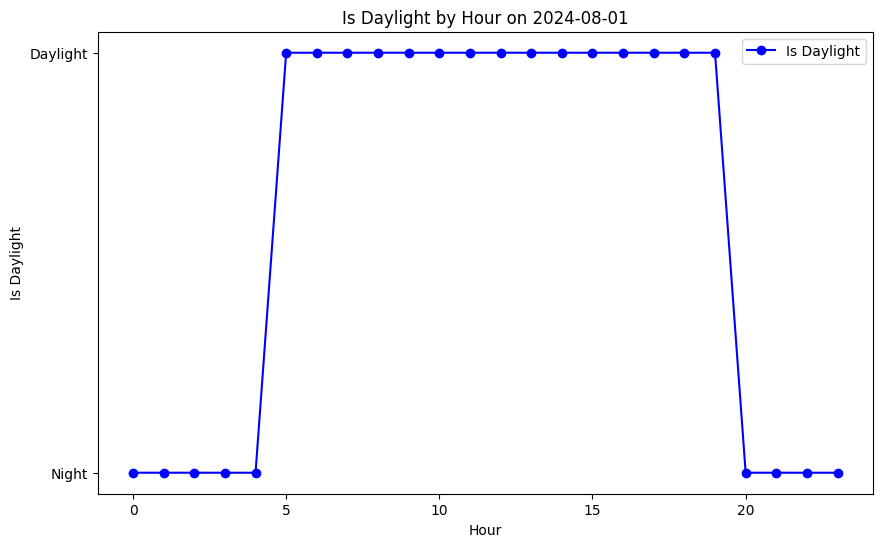

In [ ]:
# Filter the daylight_df for the specific date and create a copy
specific_date = '2024-08-01'
filtered_daylight_df = daylight_df[daylight_df['date'].dt.strftime('%Y-%m-%d') == specific_date].copy()

# Plotting
plt.figure(figsize=(10, 6))

# Plot is_daylight against the hour
plt.plot(filtered_daylight_df['hour'], filtered_daylight_df['is_daylight'], marker='o', linestyle='-', color='blue', label='Is Daylight')

# Adding titles and labels
plt.title('Is Daylight by Hour on 2024-08-01')
plt.xlabel('Hour')
plt.ylabel('Is Daylight')
plt.yticks([0, 1], ['Night', 'Daylight'])
plt.legend()

# Display the plot
plt.show()


In [ ]:
# Check the data type of the 'date' column
print(weather_hourly_dataframe['date'].dtype)

# Display the first few rows of the 'date' column
print(weather_hourly_dataframe['date'].head())


datetime64[ns]
0   2022-01-01 00:00:00
1   2022-01-01 01:00:00
2   2022-01-01 02:00:00
3   2022-01-01 03:00:00
4   2022-01-01 04:00:00
Name: date, dtype: datetime64[ns]


In [ ]:
# Attempt to force the conversion to datetime
weather_hourly_dataframe['date'] = pd.to_datetime(weather_hourly_dataframe['date'], errors='coerce')

# Check for any null values that may have resulted from failed conversions
print(weather_hourly_dataframe[weather_hourly_dataframe['date'].isnull()])


Empty DataFrame
Columns: [date, temperature_2m, relative_humidity_2m, dew_point_2m, precipitation, snowfall, snow_depth, cloud_cover, cloud_cover_low, cloud_cover_mid, cloud_cover_high, wind_speed_10m, wind_gusts_10m, is_day, sunshine_duration, global_tilted_irradiance]
Index: []


#Add the sun data to the historical weather data and save again

In [ ]:
weather_hourly_dataframe.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23832 entries, 0 to 23831
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      23832 non-null  datetime64[ns]
 1   temperature_2m            23832 non-null  float32       
 2   relative_humidity_2m      23832 non-null  float32       
 3   dew_point_2m              23832 non-null  float32       
 4   precipitation             23832 non-null  float32       
 5   snowfall                  23832 non-null  float32       
 6   snow_depth                23322 non-null  float32       
 7   cloud_cover               23832 non-null  float32       
 8   cloud_cover_low           23832 non-null  float32       
 9   cloud_cover_mid           23832 non-null  float32       
 10  cloud_cover_high          23832 non-null  float32       
 11  wind_speed_10m            23832 non-null  float32       
 12  wind_gusts_10m    

In [ ]:
weather_hourly_dataframe

,date,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,snowfall,snow_depth,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,wind_speed_10m,wind_gusts_10m,is_day,sunshine_duration,global_tilted_irradiance
0,2022-01-01 00:00:00,30.799400,92.598465,28.909401,0.0,0.0,0.131234,60.299999,67.0,0.0,0.0,6.267593,11.856100,0.0,0.0,0.0
1,2022-01-01 01:00:00,29.179399,92.888649,27.379400,0.0,0.0,0.131234,87.299995,97.0,0.0,0.0,6.109918,11.632400,0.0,0.0,0.0
2,2022-01-01 02:00:00,29.629400,93.591866,28.009399,0.0,0.0,0.131234,89.099998,99.0,0.0,0.0,6.105822,11.408700,0.0,0.0,0.0
3,2022-01-01 03:00:00,29.449400,93.586723,27.829399,0.0,0.0,0.131234,90.000000,100.0,0.0,0.0,5.317288,11.184999,0.0,0.0,0.0
4,2022-01-01 04:00:00,28.729401,94.262344,27.289400,0.0,0.0,0.131234,71.099998,79.0,0.0,0.0,3.257121,9.842800,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23827,2024-09-19 19:00:00,68.869400,62.318451,55.459400,0.0,0.0,NaN,30.000002,0.0,0.0,100.0,5.002084,8.948000,0.0,0.0,0.0
23828,2024-09-19 20:00:00,67.609398,65.930824,55.819401,0.0,0.0,NaN,30.000002,0.0,0.0,100.0,4.501876,8.053200,0.0,0.0,0.0
23829,2024-09-19 21:00:00,67.159401,66.743866,55.729401,0.0,0.0,NaN,30.000002,0.0,0.0,100.0,4.966946,7.382100,0.0,0.0,0.0
23830,2024-09-19 22:00:00,66.259399,70.213364,56.269402,0.0,0.0,NaN,30.000002,0.0,0.0,100.0,4.343469,7.382100,0.0,0.0,0.0


In [ ]:
# Ensure 'date' columns are in datetime format and timezone-naive
weather_hourly_dataframe['date'] = pd.to_datetime(weather_hourly_dataframe['date']).dt.tz_localize(None)
daylight_df['date_timestamp'] = pd.to_datetime(daylight_df['date_timestamp']).dt.tz_localize(None)

# Optional: Round to nearest hour
weather_hourly_dataframe['date_rounded'] = weather_hourly_dataframe['date'].dt.floor('H')
daylight_df['date_timestamp_rounded'] = daylight_df['date_timestamp'].dt.floor('H')

# Perform the merge on the rounded datetime columns
merged_weather_df = pd.merge(weather_hourly_dataframe, daylight_df, left_on='date_rounded', right_on='date_timestamp_rounded', how='left')

# Drop duplicate or unnecessary columns after the merge
merged_weather_df.drop(columns=['date_y', 'date_rounded', 'date_timestamp_rounded'], inplace=True, errors='ignore')

# Display a sample of the merged DataFrame to check the results
print(merged_weather_df.head())



               date_x  temperature_2m  relative_humidity_2m  dew_point_2m  \
0 2022-01-01 00:00:00       30.799400             92.598465     28.909401   
1 2022-01-01 01:00:00       29.179399             92.888649     27.379400   
2 2022-01-01 02:00:00       29.629400             93.591866     28.009399   
3 2022-01-01 03:00:00       29.449400             93.586723     27.829399   
4 2022-01-01 04:00:00       28.729401             94.262344     27.289400   

   precipitation  snowfall  snow_depth  cloud_cover  cloud_cover_low  \
0            0.0       0.0    0.131234    60.299999             67.0   
1            0.0       0.0    0.131234    87.299995             97.0   
2            0.0       0.0    0.131234    89.099998             99.0   
3            0.0       0.0    0.131234    90.000000            100.0   
4            0.0       0.0    0.131234    71.099998             79.0   

   cloud_cover_mid  ...  global_tilted_irradiance  hour  is_daylight  \
0              0.0  ...         

In [ ]:
merged_weather_df

,date_x,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,snowfall,snow_depth,cloud_cover,cloud_cover_low,cloud_cover_mid,...,global_tilted_irradiance,hour,is_daylight,solar_angle,solar_azimuth,sunrise_hour,sunset_hour,sunset,sunrise,date_timestamp
0,2022-01-01 00:00:00,30.799400,92.598465,28.909401,0.0,0.0,0.131234,60.299999,67.0,0.0,...,0.0,0,0,-70.688555,3.056930,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,2022-01-01 00:00:00
1,2022-01-01 01:00:00,29.179399,92.888649,27.379400,0.0,0.0,0.131234,87.299995,97.0,0.0,...,0.0,1,0,-66.512771,39.814783,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,2022-01-01 01:00:00
2,2022-01-01 02:00:00,29.629400,93.591866,28.009399,0.0,0.0,0.131234,89.099998,99.0,0.0,...,0.0,2,0,-57.778016,63.069547,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,2022-01-01 02:00:00
3,2022-01-01 03:00:00,29.449400,93.586723,27.829399,0.0,0.0,0.131234,90.000000,100.0,0.0,...,0.0,3,0,-47.315025,78.020430,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,2022-01-01 03:00:00
4,2022-01-01 04:00:00,28.729401,94.262344,27.289400,0.0,0.0,0.131234,71.099998,79.0,0.0,...,0.0,4,0,-36.299107,89.240580,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,2022-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23827,2024-09-19 19:00:00,68.869400,62.318451,55.459400,0.0,0.0,NaN,30.000002,0.0,0.0,...,0.0,19,0,-1.832157,273.147517,6,18,2024-09-19 18:53:27.883368-05:00,2024-09-19 06:37:13.692885-05:00,2024-09-19 19:00:00
23828,2024-09-19 20:00:00,67.609398,65.930824,55.819401,0.0,0.0,NaN,30.000002,0.0,0.0,...,0.0,20,0,-12.953039,283.473632,6,18,2024-09-19 18:53:27.883368-05:00,2024-09-19 06:37:13.692885-05:00,2024-09-19 20:00:00
23829,2024-09-19 21:00:00,67.159401,66.743866,55.729401,0.0,0.0,NaN,30.000002,0.0,0.0,...,0.0,21,0,-23.453341,294.788314,6,18,2024-09-19 18:53:27.883368-05:00,2024-09-19 06:37:13.692885-05:00,2024-09-19 21:00:00
23830,2024-09-19 22:00:00,66.259399,70.213364,56.269402,0.0,0.0,NaN,30.000002,0.0,0.0,...,0.0,22,0,-32.943470,308.011607,6,18,2024-09-19 18:53:27.883368-05:00,2024-09-19 06:37:13.692885-05:00,2024-09-19 22:00:00


In [ ]:
merged_weather_df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23832 entries, 0 to 23831
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype                          
---  ------                    --------------  -----                          
 0   date_x                    23832 non-null  datetime64[ns]                 
 1   temperature_2m            23832 non-null  float32                        
 2   relative_humidity_2m      23832 non-null  float32                        
 3   dew_point_2m              23832 non-null  float32                        
 4   precipitation             23832 non-null  float32                        
 5   snowfall                  23832 non-null  float32                        
 6   snow_depth                23322 non-null  float32                        
 7   cloud_cover               23832 non-null  float32                        
 8   cloud_cover_low           23832 non-null  float32                        
 9   cloud_cover_mid  

###There are a few time slots missing weather information, fill them with the value from the hour before it.

In [ ]:
# First, sort the DataFrame by the 'date_x' column to ensure proper order
merged_weather_df = merged_weather_df.sort_values(by='date_x')

# Then, fill null values in the specified columns with the value from the previous row using ffill()
merged_weather_df[['temperature_2m', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high']] = merged_weather_df[['temperature_2m', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high']].ffill()

# Display the first few rows of the DataFrame to verify the changes
print(merged_weather_df.head())


               date_x  temperature_2m  relative_humidity_2m  dew_point_2m  \
0 2022-01-01 00:00:00       30.799400             92.598465     28.909401   
1 2022-01-01 01:00:00       29.179399             92.888649     27.379400   
2 2022-01-01 02:00:00       29.629400             93.591866     28.009399   
3 2022-01-01 03:00:00       29.449400             93.586723     27.829399   
4 2022-01-01 04:00:00       28.729401             94.262344     27.289400   

   precipitation  snowfall  snow_depth  cloud_cover  cloud_cover_low  \
0            0.0       0.0    0.131234    60.299999             67.0   
1            0.0       0.0    0.131234    87.299995             97.0   
2            0.0       0.0    0.131234    89.099998             99.0   
3            0.0       0.0    0.131234    90.000000            100.0   
4            0.0       0.0    0.131234    71.099998             79.0   

   cloud_cover_mid  ...  global_tilted_irradiance  hour  is_daylight  \
0              0.0  ...         

                 date_x  hour  is_daylight  is_day
7   2022-01-01 07:00:00     7            1     0.0
31  2022-01-02 07:00:00     7            1     0.0
55  2022-01-03 07:00:00     7            1     0.0
79  2022-01-04 07:00:00     7            1     0.0
103 2022-01-05 07:00:00     7            1     0.0
127 2022-01-06 07:00:00     7            1     0.0
151 2022-01-07 07:00:00     7            1     0.0
175 2022-01-08 07:00:00     7            1     0.0
199 2022-01-09 07:00:00     7            1     0.0
223 2022-01-10 07:00:00     7            1     0.0
247 2022-01-11 07:00:00     7            1     0.0
271 2022-01-12 07:00:00     7            1     0.0
295 2022-01-13 07:00:00     7            1     0.0
319 2022-01-14 07:00:00     7            1     0.0
343 2022-01-15 07:00:00     7            1     0.0
367 2022-01-16 07:00:00     7            1     0.0
391 2022-01-17 07:00:00     7            1     0.0
415 2022-01-18 07:00:00     7            1     0.0
439 2022-01-19 07:00:00     7  

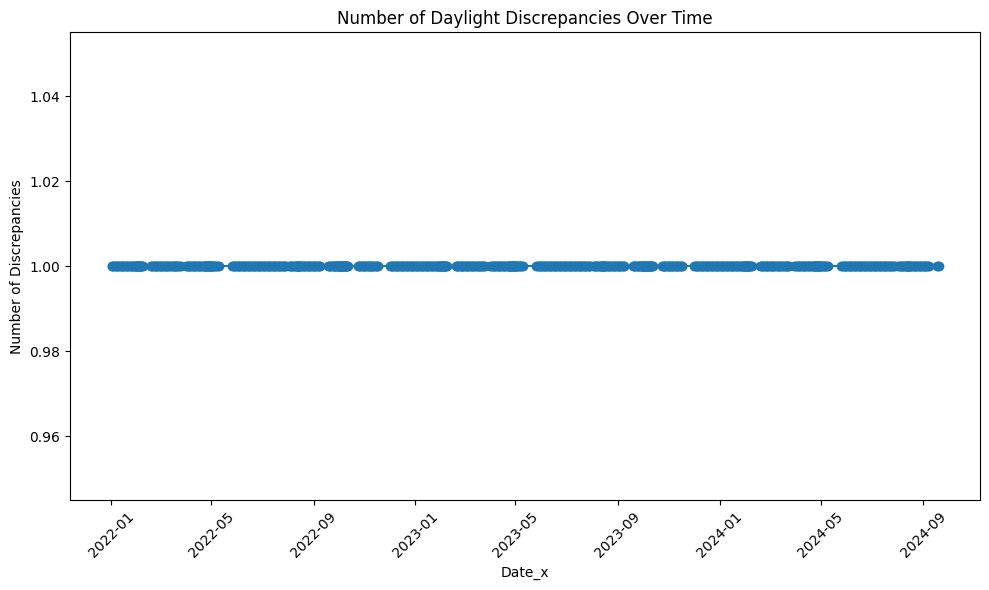

In [ ]:
# Filter the DataFrame to find where is_daylight and is_day do not match
discrepancies_df = merged_weather_df[merged_weather_df['is_daylight'] != merged_weather_df['is_day']]

# Display the first few rows to inspect the discrepancies
print(discrepancies_df[['date_x', 'hour', 'is_daylight', 'is_day']].head(20))



# You might want to count the number of discrepancies per day to get an overview
discrepancy_summary = discrepancies_df.groupby(['date_x']).size().reset_index(name='discrepancy_count')
print(discrepancy_summary)

# If you want to visualize the discrepancies over time:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(discrepancy_summary['date_x'], discrepancy_summary['discrepancy_count'], marker='o', linestyle='-')
plt.title('Number of Daylight Discrepancies Over Time')
plt.xlabel('Date_x')
plt.ylabel('Number of Discrepancies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


                   date_x  hour  is_day  is_daylight
7     2022-01-01 07:00:00     7     0.0            1
31    2022-01-02 07:00:00     7     0.0            1
55    2022-01-03 07:00:00     7     0.0            1
79    2022-01-04 07:00:00     7     0.0            1
103   2022-01-05 07:00:00     7     0.0            1
...                   ...   ...     ...          ...
23515 2024-09-06 19:00:00    19     0.0            1
23539 2024-09-07 19:00:00    19     0.0            1
23778 2024-09-17 18:00:00    18     0.0            1
23802 2024-09-18 18:00:00    18     0.0            1
23826 2024-09-19 18:00:00    18     0.0            1

[920 rows x 4 columns]


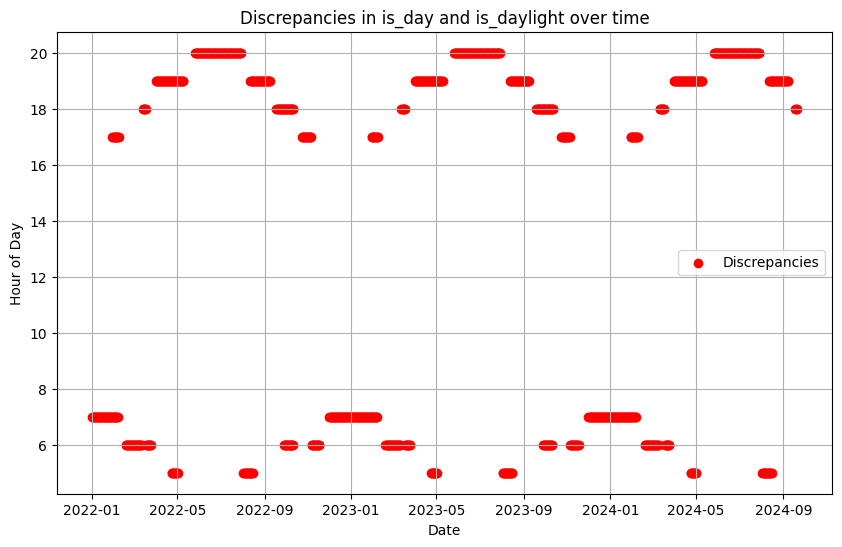

Empty DataFrame
Columns: [date_x, temperature_2m, relative_humidity_2m, dew_point_2m, precipitation, snowfall, snow_depth, cloud_cover, cloud_cover_low, cloud_cover_mid, cloud_cover_high, wind_speed_10m, wind_gusts_10m, is_day, sunshine_duration, global_tilted_irradiance, hour, is_daylight, solar_angle, solar_azimuth, sunrise_hour, sunset_hour, sunset, sunrise, date_timestamp]
Index: []

[0 rows x 25 columns]


In [ ]:
# Filter the merged_weather_df to get only the rows with discrepancies
discrepancies_df = merged_weather_df[merged_weather_df['is_day'] != merged_weather_df['is_daylight']]

# Display the discrepancies to help analyze them
print(discrepancies_df[['date_x', 'hour', 'is_day', 'is_daylight']])

# Visualize the discrepancies over time
plt.figure(figsize=(10, 6))
plt.scatter(discrepancies_df['date_x'], discrepancies_df['hour'], c='red', label='Discrepancies')
plt.title('Discrepancies in is_day and is_daylight over time')
plt.xlabel('Date')
plt.ylabel('Hour of Day')
plt.legend()
plt.grid(True)
plt.show()

# Optionally, focus on a specific date range to analyze
specific_date_range = discrepancies_df[(discrepancies_df['date_x'] >= '2024-08-01') & (discrepancies_df['date_x'] <= '2024-08-02')]
print(specific_date_range)


In [ ]:
# Display a sample of the full merged DataFrame to inspect values directly to see why the is daylight and is day fields do not line up.
#Looking at this it seems the astral numbers are correct so going to use that and not the other.
print(merged_weather_df[['date_x', 'hour', 'is_day', 'is_daylight', 'sunrise', 'sunset']].head(100))

# Optionally, check if there are any discrepancies at all
discrepancies_exist = merged_weather_df['is_day'] != merged_weather_df['is_daylight']
if discrepancies_exist.any():
    discrepancies_df = merged_weather_df[discrepancies_exist]
    print(discrepancies_df[['date_x', 'hour', 'is_day', 'is_daylight', 'sunrise', 'sunset']])
else:
    print("No discrepancies found between is_day and is_daylight.")


                date_x  hour  is_day  is_daylight  \
0  2022-01-01 00:00:00     0     0.0            0   
1  2022-01-01 01:00:00     1     0.0            0   
2  2022-01-01 02:00:00     2     0.0            0   
3  2022-01-01 03:00:00     3     0.0            0   
4  2022-01-01 04:00:00     4     0.0            0   
..                 ...   ...     ...          ...   
95 2022-01-04 23:00:00    23     0.0            0   
96 2022-01-05 00:00:00     0     0.0            0   
97 2022-01-05 01:00:00     1     0.0            0   
98 2022-01-05 02:00:00     2     0.0            0   
99 2022-01-05 03:00:00     3     0.0            0   

                            sunrise                           sunset  
0  2022-01-01 07:21:28.269561-06:00 2022-01-01 16:30:21.838422-06:00  
1  2022-01-01 07:21:28.269561-06:00 2022-01-01 16:30:21.838422-06:00  
2  2022-01-01 07:21:28.269561-06:00 2022-01-01 16:30:21.838422-06:00  
3  2022-01-01 07:21:28.269561-06:00 2022-01-01 16:30:21.838422-06:00  
4  2022-

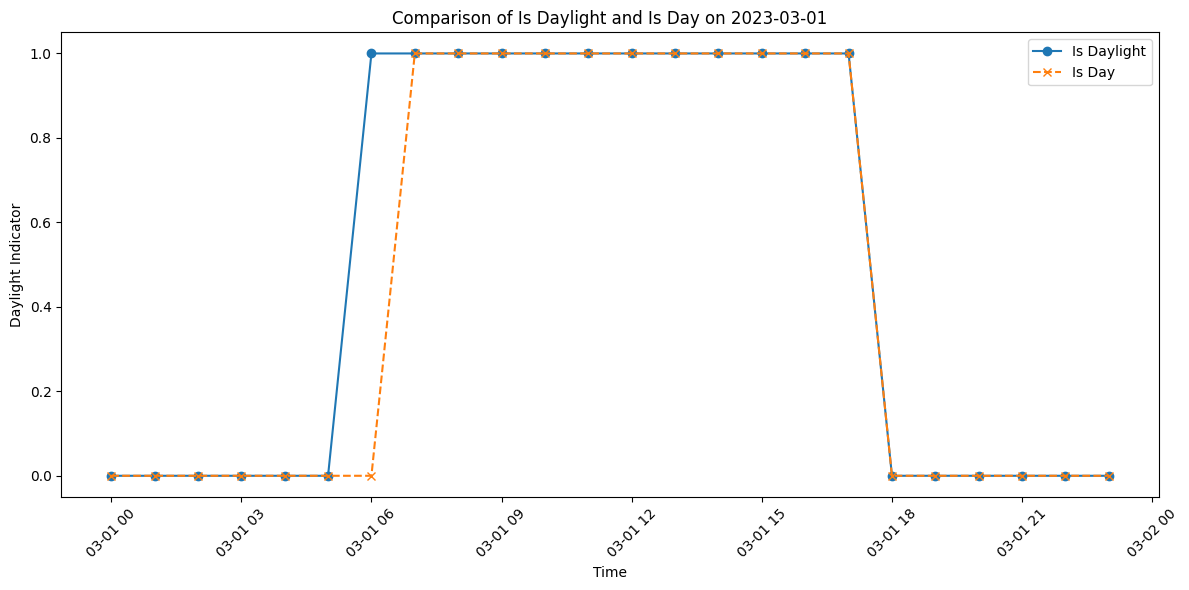

In [ ]:
# Filter the data for a specific day to visualize the discrepancies
specific_date = '2023-03-01'
discrepancy_df = merged_weather_df[merged_weather_df['date_x'].dt.strftime('%Y-%m-%d') == specific_date]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(discrepancy_df['date_x'], discrepancy_df['is_daylight'], label='Is Daylight', marker='o', linestyle='-')
plt.plot(discrepancy_df['date_x'], discrepancy_df['is_day'], label='Is Day', marker='x', linestyle='--')

# Adding titles and labels
plt.title(f'Comparison of Is Daylight and Is Day on {specific_date}')
plt.xlabel('Time')
plt.ylabel('Daylight Indicator')
plt.legend()

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


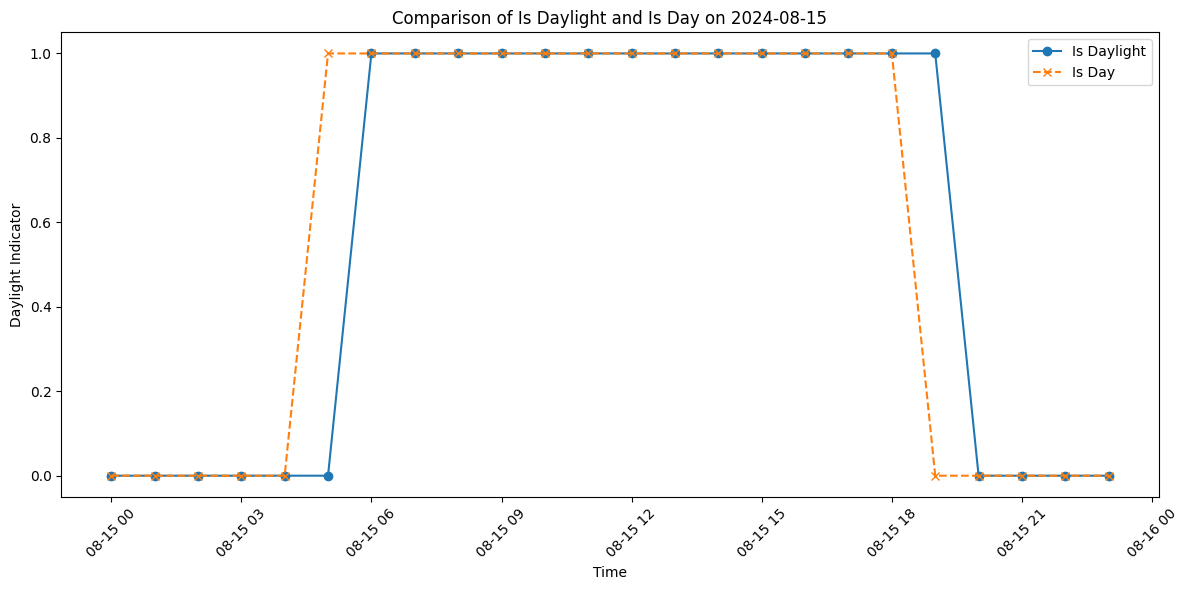

In [ ]:
# Filter the data for a specific day to visualize the discrepancies
specific_date = '2024-08-15'
discrepancy_df = merged_weather_df[merged_weather_df['date_x'].dt.strftime('%Y-%m-%d') == specific_date]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(discrepancy_df['date_x'], discrepancy_df['is_daylight'], label='Is Daylight', marker='o', linestyle='-')
plt.plot(discrepancy_df['date_x'], discrepancy_df['is_day'], label='Is Day', marker='x', linestyle='--')

# Adding titles and labels
plt.title(f'Comparison of Is Daylight and Is Day on {specific_date}')
plt.xlabel('Time')
plt.ylabel('Daylight Indicator')
plt.legend()

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


#Drop is_day from the dataframe because it is not reliable.
- I suspect because the time zone was incorrect on the weather data, the is_day identifier is also off.
- Not going to use is_day

In [ ]:
# Drop the 'is_day' column from merged_weather_df
merged_weather_df.drop(columns=['is_day'], inplace=True)




In [ ]:
# Verify the column has been dropped
merged_weather_df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23832 entries, 0 to 23831
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype                          
---  ------                    --------------  -----                          
 0   date_x                    23832 non-null  datetime64[ns]                 
 1   temperature_2m            23832 non-null  float32                        
 2   relative_humidity_2m      23832 non-null  float32                        
 3   dew_point_2m              23832 non-null  float32                        
 4   precipitation             23832 non-null  float32                        
 5   snowfall                  23832 non-null  float32                        
 6   snow_depth                23322 non-null  float32                        
 7   cloud_cover               23832 non-null  float32                        
 8   cloud_cover_low           23832 non-null  float32                        
 9   cloud_cover_mid  

In [ ]:
# Save the updated DataFrame
merged_weather_df.to_pickle('/content/drive/My Drive/iptv_weather_data_final.pkl')
print("Weather data saved.")

Weather data saved.


#Populate Future State Weather.
- Populate the future weather with the actual weather that happened in each historical Month/Day/Hour match.

In [ ]:
# Step 1: Exclude astro fields from median calculation
columns_to_exclude = ['is_daylight', 'solar_angle', 'solar_azimuth', 'sunrise_hour',
                      'sunset_hour', 'sunset', 'sunrise', 'date_timestamp', 'data_type']

numeric_columns = merged_weather_df.select_dtypes(include=['number']).columns.difference(columns_to_exclude).tolist()

# Step 2: Create 'day_hour' for mapping
merged_weather_df['day_hour'] = merged_weather_df['date_timestamp'].dt.strftime('%m-%d %H')
day_hour_medians = merged_weather_df.groupby('day_hour')[numeric_columns].median()

# Step 3: Prepare the future weather DataFrame by filtering from daylight_df
last_historical_date = merged_weather_df['date_timestamp'].max()
future_weather_df = daylight_df[daylight_df['date_timestamp'] > last_historical_date].copy()

# Step 4: Create 'day_hour' for future data and map historical medians
future_weather_df['day_hour'] = future_weather_df['date_timestamp'].dt.strftime('%m-%d %H')

# Populate future data using historical medians
for column in numeric_columns:
    future_weather_df[column] = future_weather_df['day_hour'].map(day_hour_medians[column])

# Step 5: Fill any NaN values (if no exact day_hour match is found)
for column in numeric_columns:
    future_weather_df[column].fillna(merged_weather_df[column].median(), inplace=True)

# Step 6: Mark original data as 'actual' and future data as 'estimated'
merged_weather_df['data_type'] = 'actual'
future_weather_df['data_type'] = 'estimated'

# Step 7: Concatenate the historical and future data
final_df = pd.concat([merged_weather_df, future_weather_df], ignore_index=True)

# Step 8: Verify the date range of the final DataFrame
min_max_dates = {
    'date_x': {
        'min': final_df['date_x'].min(),
        'max': final_df['date_x'].max()
    },
    'date_timestamp': {
        'min': final_df['date_timestamp'].min(),
        'max': final_df['date_timestamp'].max()
    }
}

min_max_dates_df = pd.DataFrame(min_max_dates)
print(min_max_dates_df)
final_df


                 date_x      date_timestamp
min 2022-01-01 00:00:00 2022-01-01 00:00:00
max 2024-09-19 23:00:00 2034-12-31 23:00:00


,date_x,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,snowfall,snow_depth,cloud_cover,cloud_cover_low,cloud_cover_mid,...,solar_azimuth,sunrise_hour,sunset_hour,sunset,sunrise,date_timestamp,day_hour,data_type,date,date_timestamp_rounded
0,2022-01-01 00:00:00,30.799400,92.598465,28.909401,0.0,0.0,0.131234,60.299999,67.0,0.0,...,3.056930,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,2022-01-01 00:00:00,01-01 00,actual,NaT,NaT
1,2022-01-01 01:00:00,29.179399,92.888649,27.379400,0.0,0.0,0.131234,87.299995,97.0,0.0,...,39.814783,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,2022-01-01 01:00:00,01-01 01,actual,NaT,NaT
2,2022-01-01 02:00:00,29.629400,93.591866,28.009399,0.0,0.0,0.131234,89.099998,99.0,0.0,...,63.069547,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,2022-01-01 02:00:00,01-01 02,actual,NaT,NaT
3,2022-01-01 03:00:00,29.449400,93.586723,27.829399,0.0,0.0,0.131234,90.000000,100.0,0.0,...,78.020430,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,2022-01-01 03:00:00,01-01 03,actual,NaT,NaT
4,2022-01-01 04:00:00,28.729401,94.262344,27.289400,0.0,0.0,0.131234,71.099998,79.0,0.0,...,89.240580,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,2022-01-01 04:00:00,01-01 04,actual,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113947,NaT,30.124401,91.745247,28.009399,0.0,0.0,0.000000,30.300003,0.0,0.5,...,262.454319,7,16,2034-12-31 16:29:22.454990-06:00,2034-12-31 07:21:17.637023-06:00,2034-12-31 19:00:00,12-31 19,estimated,2034-12-31,2034-12-31 19:00:00
113948,NaT,29.539400,91.557083,27.379400,0.0,0.0,0.000000,55.050003,1.5,39.5,...,272.252301,7,16,2034-12-31 16:29:22.454990-06:00,2034-12-31 07:21:17.637023-06:00,2034-12-31 20:00:00,12-31 20,estimated,2034-12-31,2034-12-31 20:00:00
113949,NaT,28.819401,91.700851,26.704399,0.0,0.0,0.000000,61.350002,1.5,50.0,...,283.851877,7,16,2034-12-31 16:29:22.454990-06:00,2034-12-31 07:21:17.637023-06:00,2034-12-31 21:00:00,12-31 21,estimated,2034-12-31,2034-12-31 21:00:00
113950,NaT,28.594398,91.843277,26.524399,0.0,0.0,0.000000,65.000000,20.0,43.0,...,299.669257,7,16,2034-12-31 16:29:22.454990-06:00,2034-12-31 07:21:17.637023-06:00,2034-12-31 22:00:00,12-31 22,estimated,2034-12-31,2034-12-31 22:00:00


In [ ]:
#`date` and `date_timestamp_rounded` are not needed
columns_to_drop = ['date_x', 'date', 'date_timestamp_rounded']

# Ensure merged_weather_df and future_weather_df do not carry unnecessary fields
final_df = final_df.drop(columns=columns_to_drop, errors='ignore')
final_df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113952 entries, 0 to 113951
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype                          
---  ------                    --------------   -----                          
 0   temperature_2m            113952 non-null  float32                        
 1   relative_humidity_2m      113952 non-null  float32                        
 2   dew_point_2m              113952 non-null  float32                        
 3   precipitation             113952 non-null  float32                        
 4   snowfall                  113952 non-null  float32                        
 5   snow_depth                113442 non-null  float32                        
 6   cloud_cover               113952 non-null  float32                        
 7   cloud_cover_low           113952 non-null  float32                        
 8   cloud_cover_mid           113952 non-null  float32                        
 9   clou

In [ ]:
# Define the desired column order
desired_order = [
    'date_timestamp', 'day_hour', 'hour','temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'precipitation', 'snowfall', 'snow_depth',
    'cloud_cover','cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high','wind_speed_10m', 'wind_gusts_10m', 'sunshine_duration', 'global_tilted_irradiance',
    'is_daylight', 'solar_angle', 'solar_azimuth',
    'sunrise_hour', 'sunset_hour', 'sunset', 'sunrise', 'data_type'
]

# Reorder the DataFrame columns
final_df = final_df[desired_order]

# Display the first few rows to verify the order
print(final_df.head())

       date_timestamp  day_hour  hour  temperature_2m  relative_humidity_2m  \
0 2022-01-01 00:00:00  01-01 00   0.0       30.799400             92.598465   
1 2022-01-01 01:00:00  01-01 01   1.0       29.179399             92.888649   
2 2022-01-01 02:00:00  01-01 02   2.0       29.629400             93.591866   
3 2022-01-01 03:00:00  01-01 03   3.0       29.449400             93.586723   
4 2022-01-01 04:00:00  01-01 04   4.0       28.729401             94.262344   

   dew_point_2m  precipitation  snowfall  snow_depth  cloud_cover  ...  \
0     28.909401            0.0       0.0    0.131234    60.299999  ...   
1     27.379400            0.0       0.0    0.131234    87.299995  ...   
2     28.009399            0.0       0.0    0.131234    89.099998  ...   
3     27.829399            0.0       0.0    0.131234    90.000000  ...   
4     27.289400            0.0       0.0    0.131234    71.099998  ...   

   sunshine_duration  global_tilted_irradiance  is_daylight  solar_angle  \
0   

In [ ]:
final_df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113952 entries, 0 to 113951
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype                          
---  ------                    --------------   -----                          
 0   date_timestamp            113952 non-null  datetime64[ns]                 
 1   day_hour                  113952 non-null  object                         
 2   hour                      113952 non-null  float64                        
 3   temperature_2m            113952 non-null  float32                        
 4   relative_humidity_2m      113952 non-null  float32                        
 5   dew_point_2m              113952 non-null  float32                        
 6   precipitation             113952 non-null  float32                        
 7   snowfall                  113952 non-null  float32                        
 8   snow_depth                113442 non-null  float32                        
 9   clou

In [ ]:
final_df

,date_timestamp,day_hour,hour,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,snowfall,snow_depth,cloud_cover,...,sunshine_duration,global_tilted_irradiance,is_daylight,solar_angle,solar_azimuth,sunrise_hour,sunset_hour,sunset,sunrise,data_type
0,2022-01-01 00:00:00,01-01 00,0.0,30.799400,92.598465,28.909401,0.0,0.0,0.131234,60.299999,...,0.0,0.0,0,-70.688555,3.056930,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,actual
1,2022-01-01 01:00:00,01-01 01,1.0,29.179399,92.888649,27.379400,0.0,0.0,0.131234,87.299995,...,0.0,0.0,0,-66.512771,39.814783,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,actual
2,2022-01-01 02:00:00,01-01 02,2.0,29.629400,93.591866,28.009399,0.0,0.0,0.131234,89.099998,...,0.0,0.0,0,-57.778016,63.069547,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,actual
3,2022-01-01 03:00:00,01-01 03,3.0,29.449400,93.586723,27.829399,0.0,0.0,0.131234,90.000000,...,0.0,0.0,0,-47.315025,78.020430,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,actual
4,2022-01-01 04:00:00,01-01 04,4.0,28.729401,94.262344,27.289400,0.0,0.0,0.131234,71.099998,...,0.0,0.0,0,-36.299107,89.240580,7,16,2022-01-01 16:30:21.838422-06:00,2022-01-01 07:21:28.269561-06:00,actual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113947,2034-12-31 19:00:00,12-31 19,19.0,30.124401,91.745247,28.009399,0.0,0.0,0.000000,30.300003,...,0.0,0.0,0,-26.893894,262.454319,7,16,2034-12-31 16:29:22.454990-06:00,2034-12-31 07:21:17.637023-06:00,estimated
113948,2034-12-31 20:00:00,12-31 20,20.0,29.539400,91.557083,27.379400,0.0,0.0,0.000000,55.050003,...,0.0,0.0,0,-37.962894,272.252301,7,16,2034-12-31 16:29:22.454990-06:00,2034-12-31 07:21:17.637023-06:00,estimated
113949,2034-12-31 21:00:00,12-31 21,21.0,28.819401,91.700851,26.704399,0.0,0.0,0.000000,61.350002,...,0.0,0.0,0,-48.934295,283.851877,7,16,2034-12-31 16:29:22.454990-06:00,2034-12-31 07:21:17.637023-06:00,estimated
113950,2034-12-31 22:00:00,12-31 22,22.0,28.594398,91.843277,26.524399,0.0,0.0,0.000000,65.000000,...,0.0,0.0,0,-59.239961,299.669257,7,16,2034-12-31 16:29:22.454990-06:00,2034-12-31 07:21:17.637023-06:00,estimated


In [ ]:
# Save the updated DataFrame
final_df.to_pickle('/content/drive/My Drive/iptv_weather_all_data_raw.pkl')
print("Weather data saved.")

Weather data saved.


#Future Electric

- The median usage and cost of electricity will be taken for each hour within a month and applied for that month into the future. So, as an example, the month of January 2023 will calculate the median usage and cost at 12pm across all days in that January and apply them into the future.

In [ ]:
# Load the DataFrame from the pickle file
electric_agg = pd.read_pickle('/content/drive/My Drive/iptv_electric_data_cleaned.pkl')

# Verify that the data was loaded correctly
print(electric_agg.head())


        DATE  hour last_day_month  USAGE_(kWh)  COST  ESTIMATED_USAGE  \
0 2023-01-01     0     2023-01-31         1.46  0.22              0.0   
1 2023-01-01     1     2023-01-31         1.52  0.17              0.0   
2 2023-01-01     2     2023-01-31         1.14  0.24              0.0   
3 2023-01-01     3     2023-01-31         1.64  0.41              0.0   
4 2023-01-01     4     2023-01-31         2.74  0.14              0.0   

       date_timestamp  cost_per_kWh  
0 2023-01-01 00:00:00      0.150685  
1 2023-01-01 01:00:00      0.111842  
2 2023-01-01 02:00:00      0.210526  
3 2023-01-01 03:00:00      0.250000  
4 2023-01-01 04:00:00      0.051095  


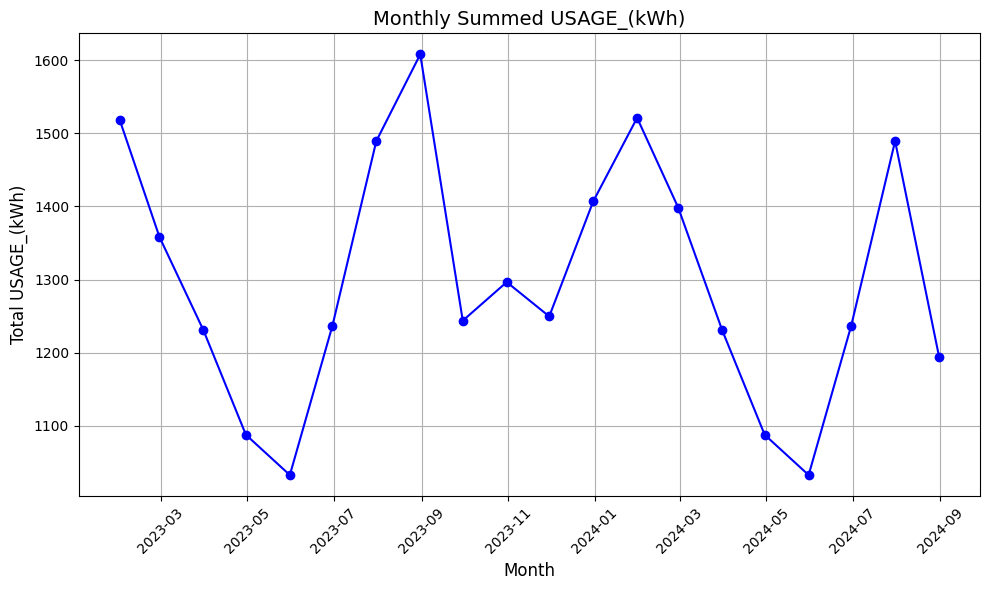

In [ ]:
# Ensure 'DATE' is in datetime format
electric_agg['DATE'] = pd.to_datetime(electric_agg['DATE'])

# Step 1: Resample the data by month and sum the 'USAGE_(kWh)'
monthly_usage = electric_agg.resample('M', on='DATE')['USAGE_(kWh)'].sum()

# Step 2: Plot the monthly summed usage
plt.figure(figsize=(10, 6))
plt.plot(monthly_usage.index, monthly_usage.values, marker='o', linestyle='-', color='b', label='USAGE_(kWh)')

# Adding titles and labels
plt.title('Monthly Summed USAGE_(kWh)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total USAGE_(kWh)', fontsize=12)

# Display the plot
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#Populate the future dates

In [ ]:
import pandas as pd
import numpy as np

# Ensure the 'DATE' column is in datetime format
electric_agg['DATE'] = pd.to_datetime(electric_agg['DATE'])

# Add 'month', 'day', and 'hour' columns to the dataframe for grouping
electric_agg['month'] = electric_agg['DATE'].dt.month
electric_agg['day'] = electric_agg['DATE'].dt.day
electric_agg['hour'] = electric_agg['DATE'].dt.hour

# Step 1: Generate future timestamps (starting from the last available timestamp in the data)
last_timestamp = electric_agg['DATE'].max()
future_timestamps = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1),
                                  end='2034-12-31 23:00:00', freq='H')

# Step 2: Create a DataFrame for the future data
future_electric = pd.DataFrame({
    'date_timestamp': future_timestamps,
    'DATE': future_timestamps.date,
    'month': future_timestamps.month,
    'day': future_timestamps.day,
    'hour': future_timestamps.hour
})

# Step 3: Merge future data with the 'USAGE_(kWh)' and 'cost_per_kWh' columns
# Merging based on 'month', 'day', and 'hour' to project future data more accurately
future_electric = future_electric.merge(electric_agg[['month', 'day', 'hour', 'USAGE_(kWh)', 'cost_per_kWh']],
                                        on=['month', 'day', 'hour'], how='left')

# Step 4: Add the last_day_month column by converting 'DATE' column to datetime
future_electric['last_day_month'] = pd.to_datetime(future_electric['DATE']).apply(lambda x: x.replace(day=1) + pd.offsets.MonthEnd(1))

# Step 5: Mark the original data as 'actual' and the future data as 'estimated'
electric_agg['data_type'] = 'actual'
future_electric['data_type'] = 'estimated'

# Step 6: Concatenate the original data and the future data
final_electric_agg = pd.concat([electric_agg, future_electric], ignore_index=True)

# Display the final DataFrame
print(final_electric_agg.head())


                  DATE  hour last_day_month  USAGE_(kWh)  COST  \
0  2023-01-01 00:00:00     0     2023-01-31         1.46  0.22   
1  2023-01-01 00:00:00     0     2023-01-31         1.52  0.17   
2  2023-01-01 00:00:00     0     2023-01-31         1.14  0.24   
3  2023-01-01 00:00:00     0     2023-01-31         1.64  0.41   
4  2023-01-01 00:00:00     0     2023-01-31         2.74  0.14   

   ESTIMATED_USAGE      date_timestamp  cost_per_kWh  month  day data_type  
0              0.0 2023-01-01 00:00:00      0.150685      1    1    actual  
1              0.0 2023-01-01 01:00:00      0.111842      1    1    actual  
2              0.0 2023-01-01 02:00:00      0.210526      1    1    actual  
3              0.0 2023-01-01 03:00:00      0.250000      1    1    actual  
4              0.0 2023-01-01 04:00:00      0.051095      1    1    actual  


In [ ]:
# Save the updated DataFrame
final_electric_agg.to_pickle('/content/drive/My Drive/iptv_future_electric_data.pkl')
print("Electric data saved.")

Electric data saved.


In [ ]:
# Load the DataFrame from the pickle file
final_electric_agg = pd.read_pickle('/content/drive/My Drive/iptv_future_electric_data.pkl')

# Verify that the data was loaded correctly by printing the first few rows
print(final_electric_agg.head())


                  DATE  hour last_day_month  USAGE_(kWh)  COST  \
0  2023-01-01 00:00:00     0     2023-01-31         1.46  0.22   
1  2023-01-01 00:00:00     0     2023-01-31         1.52  0.17   
2  2023-01-01 00:00:00     0     2023-01-31         1.14  0.24   
3  2023-01-01 00:00:00     0     2023-01-31         1.64  0.41   
4  2023-01-01 00:00:00     0     2023-01-31         2.74  0.14   

   ESTIMATED_USAGE      date_timestamp  cost_per_kWh  month  day data_type  
0              0.0 2023-01-01 00:00:00      0.150685      1    1    actual  
1              0.0 2023-01-01 01:00:00      0.111842      1    1    actual  
2              0.0 2023-01-01 02:00:00      0.210526      1    1    actual  
3              0.0 2023-01-01 03:00:00      0.250000      1    1    actual  
4              0.0 2023-01-01 04:00:00      0.051095      1    1    actual  


In [ ]:
#DATE and ESTIMATED_USAGE are not needed
columns_to_drop = ['DATE','ESTIMATED_USAGE']

final_electric_agg = final_electric_agg.drop(columns=columns_to_drop, errors='ignore')
final_electric_agg.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248579 entries, 0 to 248578
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   hour            248579 non-null  int32         
 1   last_day_month  248579 non-null  datetime64[ns]
 2   USAGE_(kWh)     161570 non-null  float64       
 3   COST            14422 non-null   float64       
 4   date_timestamp  248579 non-null  datetime64[ns]
 5   cost_per_kWh    161515 non-null  float64       
 6   month           248579 non-null  int32         
 7   day             248579 non-null  int32         
 8   data_type       248579 non-null  object        
dtypes: datetime64[ns](2), float64(3), int32(3), object(1)
memory usage: 14.2+ MB


In [ ]:
final_electric_agg

,hour,last_day_month,USAGE_(kWh),COST,date_timestamp,cost_per_kWh,month,day,data_type
0,0,2023-01-31,1.46,0.22,2023-01-01 00:00:00,0.150685,1,1,actual
1,0,2023-01-31,1.52,0.17,2023-01-01 01:00:00,0.111842,1,1,actual
2,0,2023-01-31,1.14,0.24,2023-01-01 02:00:00,0.210526,1,1,actual
3,0,2023-01-31,1.64,0.41,2023-01-01 03:00:00,0.250000,1,1,actual
4,0,2023-01-31,2.74,0.14,2023-01-01 04:00:00,0.051095,1,1,actual
...,...,...,...,...,...,...,...,...,...
248574,19,2034-12-31,NaN,NaN,2034-12-31 19:00:00,NaN,12,31,estimated
248575,20,2034-12-31,NaN,NaN,2034-12-31 20:00:00,NaN,12,31,estimated
248576,21,2034-12-31,NaN,NaN,2034-12-31 21:00:00,NaN,12,31,estimated
248577,22,2034-12-31,NaN,NaN,2034-12-31 22:00:00,NaN,12,31,estimated


In [ ]:
print(final_electric_agg['date_timestamp'].min(), final_electric_agg['date_timestamp'].max())


2023-01-01 00:00:00 2034-12-31 23:00:00


In [ ]:
final_electric_agg.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248579 entries, 0 to 248578
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   hour            248579 non-null  int32         
 1   last_day_month  248579 non-null  datetime64[ns]
 2   USAGE_(kWh)     161570 non-null  float64       
 3   COST            14422 non-null   float64       
 4   date_timestamp  248579 non-null  datetime64[ns]
 5   cost_per_kWh    161515 non-null  float64       
 6   month           248579 non-null  int32         
 7   day             248579 non-null  int32         
 8   data_type       248579 non-null  object        
dtypes: datetime64[ns](2), float64(3), int32(3), object(1)
memory usage: 14.2+ MB


In [ ]:
# Save the updated DataFrame
final_electric_agg.to_pickle('/content/drive/My Drive/iptv_future_electric_data.pkl')
print("Electric data saved.")

Electric data saved.
